## Analysis of Diving Scores from Divemeets.com

In [1]:
from IPython.display import HTML

HTML('''<script>
hide_code=true; 
function code_toggle() {
   if (hide_code){
       $('div.input').hide();
   } else {
       $('div.input').show();
   }
   hide_code = !hide_code
} 
$( document ).ready(code_toggle);
</script>
NOTE: The code in this notebook is hidden for better readability.  
To toggle the code view on/off, click <a href="javascript:code_toggle()">here</a>.''')

#### The Problem 
Many times, people sit in the stands, on the side lines, or in front of their TV watching a game, competition, or meet and thought that a referee, official, or judge was biased in their calls or scores. Is it true? Are the officiants biased or are we just seeing things from our own biased view point? <br>
Bias can be very difficult to uncover. Two athletes behaving or performing in the same manner could have different outcomes. Is this really the result of bias or did the officiant legitimately not observe something from one athlete that was seen in the other, maybe because they were looking in a different direction? Improvements in technology has aided the analysis for many of these types of situations and allows some errant calls to be corrected, but still, the question persists. <br>
The bias we are going to consider here is affiliation bias. In order to determine if there is affiliation bias, you need to know if the officiant and the athlete have a common affiliation, most likely as part of the same team. We would like to know if this bias is evident at the children’s sports level. To determine this, you need to know the events that occurred, the resulting calls or scores, and the affiliation of the athlete and the officiant. This information needs to be readily accessible for a large number of events. Diving provides a very good resource for this type of information. The website divemeets.com has the results from most diving events in the country. It contains diver names, clubs, scores from each judge for the dives, judge’s names, and judge’s affiliations or clubs. The judges are usually coaches, from the teams attending the meets. There are occasional guest judges whose affiliation would be unknown, but these are a minority of the judges. There is also a progression of meets where placing high in one meet allows the diver to advance to the next higher-level meet. <br>
Phase one of this project involved the collection of the data from the website divemeets.com using beautifulsoup for webscraping and cleaning the data so it is ready for processing. This was done previously so the process is not covered in detail here. The data collected will be used to determine if bias exists in the scores given to the divers. The null hypothesis is that there is no significant difference between the scores judges/coaches give to divers from their same team and the scores they give to divers from other teams.<br>


#### The Data 
The data collected comes from advancement meets, which are meets where a certain number of the highest placing divers advance to the next meet. These meets are the regional and zone meets. There are 12 regions and 6 zones in the USA resulting in 18 meets a year with data collected for three years, 2016, 2017, and 2018 resulting in 54 meets. There is a maximum of 24 events for which data has been collected. These events are grouped by age, gender, and board-1M, 3M, platform. The data collected includes the meet name, meet date, event name, the judge giving the score, the scores that judge gave up to a maximum of 11, any scores not given contain Nan, the diver name, diver team, and a flag named 'same' indicating the relation of the diver team to the judge team. If the diver team and judge team are not the same, the flag value is 0, if the teams are the same, the flag value is 1, and if either the diver team or the judge team is unknown, the flag value is 2. There is still a bit of data cleaning/preparation required that was discovered during the analysis process.

In [2]:
# importing pandas module  
import pandas as pd # pandas
import seaborn as sns # seaborn plotting
import numpy as np # numerical operations
from matplotlib import pyplot # plotting
import matplotlib.pyplot as plt # plotting
from scipy import stats # Stats for data set, t-test
from statsmodels.graphics.gofplots import qqplot # Plot normality of distribution
from scipy.stats import shapiro # test for normality
from scipy.stats import normaltest # test for normality
import matplotlib.mlab as mlab # mathmatical operation
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
import researchpy as rp # some of the data set stats
    
import matplotlib.pyplot as plt
import warnings # hide warning messages
warnings.filterwarnings('ignore')  # hide warning messages

plt.rcParams["figure.figsize"] = (20,10) # set figure display sizes
   
# reading csv file from containing divemeets data and assign headers  
data_org = pd.read_csv("divemeets_final_data.csv", index_col=0) 
# remove diver name since it is not being used and team has been separated from dive name
data_org.drop(columns =['diver'], inplace = True)
# remove date because year is in the meet name and we don't need the specific dates
data_org.drop(columns =['date'], inplace = True) 
data_org.head(5)

,meet,event,judge,score1,score2,score3,score4,score5,score6,score7,score8,score9,score10,score11,d_team,same
0,2016 USA Diving Junior Region 1 Championships,11 & Under Girls 3m J.O,"Judge 1 - N/A,",5.5,4.5,5.0,5.5,5.5,4.5,NaN,NaN,NaN,NaN,NaN,Whirlwind Diving (WWD),2
1,2016 USA Diving Junior Region 1 Championships,11 & Under Girls 3m J.O,"Judge 2 - N/A,",5.0,4.5,5.5,5.5,5.5,4.5,NaN,NaN,NaN,NaN,NaN,Whirlwind Diving (WWD),2
2,2016 USA Diving Junior Region 1 Championships,11 & Under Girls 3m J.O,"Judge 3 - N/A,",5.0,4.5,5.0,5.5,5.0,4.0,NaN,NaN,NaN,NaN,NaN,Whirlwind Diving (WWD),2
3,2016 USA Diving Junior Region 1 Championships,11 & Under Girls 3m J.O,"Judge 4 - N/A,",5.5,4.5,5.0,5.5,5.0,5.0,NaN,NaN,NaN,NaN,NaN,Whirlwind Diving (WWD),2
4,2016 USA Diving Junior Region 1 Championships,11 & Under Girls 3m J.O,"Judge 5 - N/A,",6.0,4.5,5.0,6.0,5.0,4.5,NaN,NaN,NaN,NaN,NaN,Whirlwind Diving (WWD),2


The meet name includes the year. There is also a different name for the zone meet for each of the three years. To create consistency in the meet names and to better group the data, the meet name field will be separated into year and meet and the names will be reduced to simply "Region [X]" and "Zone [Y]". The data file now looks like this:

In [3]:
# meet field contains year and meet name
# create a new data frame with split value columns 
new = data_org["meet"].str.split(" USA Diving ", n = 1, expand = True) 
  
# make a separate year column from new data frame 
data_org["year"]= new[0] 
  
# write over the old meet name column with the separated meet name 
data_org["meet"]= new[1] 
  
# Remove extra words from the meet name
data_org['meet'] = data_org['meet'].str.replace(r" Championships","")
data_org['meet'] = data_org['meet'].str.replace(r"Junior ","")
data_org['meet'] = data_org['meet'].str.replace(r"National ","")
data_org['meet'] = data_org['meet'].str.replace(r"Preliminary ","")
data_org['meet'] = data_org['meet'].str.replace(r" Meet","")

# Look at file to confirm changes.
data_org.tail(5)

,meet,event,judge,score1,score2,score3,score4,score5,score6,score7,score8,score9,score10,score11,d_team,same,year
226552,Zone F,16-18 Boys Platform J.O,"Miller, Chris",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.5,4.5,NaN,Sun Devil Divers (SUND),0,2018
226553,Zone F,16-18 Boys Platform J.O,"Treguboff, Lisa A",5.5,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sun Devil Divers (SUND),0,2018
226554,Zone F,16-18 Boys Platform J.O,"Ishimatsu, Victoria K",NaN,NaN,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sun Devil Divers (SUND),0,2018
226555,Zone F,16-18 Boys Platform J.O,"Treguboff, Lisa A",NaN,NaN,NaN,NaN,4.0,7.0,5.5,NaN,NaN,NaN,NaN,Sun Devil Divers (SUND),0,2018
226556,Zone F,16-18 Boys Platform J.O,"Ishimatsu, Victoria K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,NaN,Sun Devil Divers (SUND),0,2018


The list of unique meets is now as expected, 12 regions and 6 zones.

In [4]:
data_org['meet'].nunique()
data_org.meet.unique()

array(['Region 1', 'Region 2', 'Region 3', 'Region 4', 'Region 5',
       'Region 6', 'Region 7', 'Region 8', 'Region 9', 'Region 10',
       'Region 11', 'Region 12', 'Zone A', 'Zone B', 'Zone C', 'Zone D',
       'Zone E', 'Zone F'], dtype=object)

We can look at the unique score values to see if they are as expected. The scores ranged from nan to 10 in all score fields except for score11 where there were 4 cases of values greater than 10. When this was investigated, it was determined that the total of the given scores was put in the field for score 11 instead of in the field for the total on the original website from which the data was scraped. A correction was coded to remove values greater than 10 in the score11 field. This corrected the problem.

In [5]:
data_org['score11'].nunique()
data_org.score11.unique()

array([ nan,  4.5,  5.5,  5. ,  4. ,  3. ,  3.5,  2.5,  2. ,  6.5,  0. ,
        6. ,  8. ,  7.5,  7. ,  1.5,  8.5,  9. ,  1. ,  0.5, 30.5, 32.5,
       31. , 30. ,  9.5, 10. ])

Here is a list of the events included in the data file. There are 4 age groups, 11 & under, 12-13,14-15, and 16-18. Each age group has a girls and boys category making 8 different age/boy-girl combination. There are also 3 different events for each age/boy-girl group, 1 meter springboard, 3 meter springboard, and platform making a total of 24 different events. 

In [6]:
# Remove the (Opt.1st) from the events where the cut option is used
data_org['event'] = data_org['event'].str.replace(r" \(.*\)","")
data_org.event.unique()

array(['11 & Under Girls 3m J.O', '12-13 Girls 3m J.O',
       '14-15 Girls 3m J.O', '16-18 Girls Platform J.O',
       '11 & Under Boys 1m J.O', '12-13 Boys 1m J.O',
       '14-15 Boys 1m  J.O', '16-18 Boys Platform J.O',
       '11 & Under Girls 1m J.O', '12-13 Girls Platform J.O',
       '14-15 Girls 1m J.O', '16-18 Girls 1m J.O',
       '11 & Under Boys 3m J.O', '12-13 Boys Platform J.O',
       '14-15 Boys 3m J.O', '16-18 Boys 3m J.O',
       '11 & Under Girls Platform J.O', '12-13 Girls 1m J.O',
       '14-15 Girls Platform J.O', '16-18 Girls 3m J.O',
       '11 & Under Boys Platform J.O', '12-13 Boys 3m J.O',
       '14-15 Boys Platform J.O', '16-18 Boys 1m J.O'], dtype=object)

A record in the data set contains the scores from a given judge for a given diver for a maximum of 11 dives. If the judge did not give scores for eleven dives, then the score column for the dives the judge did not score is empty or contains a null. Columns will be added to the data set for the total of all scores given by a particular judge to a particular diver, the number of scores that judge gave, and the average of the scores the judge gave.

In [7]:
# add columns to store the total score, number of scores, and average score
# set the values initially to 0.
data_org["t_score"] = 0
data_org["score_cnt"] = 0
data_org["ave_score"] = 0

In [8]:
#########
# Function to set values for total score given by a judge
#
# Look at each score field, if it is not null, add the score
# to the total score. In score11 there are a few cases where
# the value represents the total score instead of the score
# for a dive. In this case, the value is greater than 10 and
# the score will be removed.
#########
def total_score(row):
    
    score_total = 0
    
    if not (pd.isnull(row['score1'])):
        score_total = score_total + row['score1']
    if not (pd.isnull(row['score2'])):
        score_total = score_total + row['score2']
    if not (pd.isnull(row['score3'])):
        score_total = score_total + row['score3']
    if not (pd.isnull(row['score4'])):
        score_total = score_total + row['score4']
    if not (pd.isnull(row['score5'])):
        score_total = score_total + row['score5']
    if not (pd.isnull(row['score6'])):
        score_total = score_total + row['score6']
    if not (pd.isnull(row['score7'])):
        score_total = score_total + row['score7']
    if not (pd.isnull(row['score8'])):
        score_total = score_total + row['score8']
    if not (pd.isnull(row['score9'])):
        score_total = score_total + row['score9']
    if not (pd.isnull(row['score10'])):
        score_total = score_total + row['score10']
    # If the score is not 0 >= and <= 10 it is not valid
    if not (pd.isnull(row['score11'])):
        if row['score11'] > 10:
            row['score11'] = ''
        else:
            score_total = score_total + row['score11']

    return score_total
        

In [9]:
#########
# Function to count number of scores given by a judge
#
# Count the number of non-null scores in a row to get
# the number of scores the judge gave in this record.
#########
def count_scores(row):
    
    score_count = 0
    
    if not (pd.isnull(row['score1'])):
        score_count += 1
    if not (pd.isnull(row['score2'])):
        score_count += 1
    if not (pd.isnull(row['score3'])):
        score_count += 1
    if not (pd.isnull(row['score4'])):
        score_count += 1
    if not (pd.isnull(row['score5'])):
        score_count += 1
    if not (pd.isnull(row['score6'])):
        score_count += 1
    if not (pd.isnull(row['score7'])):
        score_count += 1
    if not (pd.isnull(row['score8'])):
        score_count += 1
    if not (pd.isnull(row['score9'])):
        score_count += 1
    if not (pd.isnull(row['score10'])):
        score_count += 1
    if not (pd.isnull(row['score11'])):
        score_count += 1

    return score_count

In [10]:
#########
# Call the function to add up the total number of scores
# and set field 't_score' to the sum of the scores.
#########
data_org['t_score'] = data_org.apply(total_score, axis=1)

#########
# Call the function to count the total number of scores
# and set field 'score_cnt' to the count of the scores.
#########
data_org['score_cnt'] = data_org.apply(count_scores, axis=1)

#########
# Set field 'ave_score' to the average of the scores.
# Divide the score total by the number of scores.
#########
data_org['ave_score'] = data_org['t_score']/data_org['score_cnt']

This is how the data file looks with the new variables added.

In [11]:
# look at the file after the new fields are added
data_org.tail(5)

,meet,event,judge,score1,score2,score3,score4,score5,score6,score7,score8,score9,score10,score11,d_team,same,year,t_score,score_cnt,ave_score
226552,Zone F,16-18 Boys Platform J.O,"Miller, Chris",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.5,4.5,NaN,Sun Devil Divers (SUND),0,2018,15.0,3,5.000000
226553,Zone F,16-18 Boys Platform J.O,"Treguboff, Lisa A",5.5,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sun Devil Divers (SUND),0,2018,10.5,2,5.250000
226554,Zone F,16-18 Boys Platform J.O,"Ishimatsu, Victoria K",NaN,NaN,5.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sun Devil Divers (SUND),0,2018,11.0,2,5.500000
226555,Zone F,16-18 Boys Platform J.O,"Treguboff, Lisa A",NaN,NaN,NaN,NaN,4.0,7.0,5.5,NaN,NaN,NaN,NaN,Sun Devil Divers (SUND),0,2018,16.5,3,5.500000
226556,Zone F,16-18 Boys Platform J.O,"Ishimatsu, Victoria K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,NaN,Sun Devil Divers (SUND),0,2018,14.0,3,4.666667


Now that we have the total score, the number of scores, and the average score given, we will make a copy of the dataset and drop the individual score columns. This will make the dataset smaller allowing analysis and calculation to run more quickly.

In [12]:
# Make a copy of the original data
data = data_org.copy()

# Remove the individual scores since we will use the average score
data.drop(columns =['score1', 'score2', 'score3', 'score4', 'score5', 'score6',
                   'score7', 'score8', 'score9', 'score10', 'score11'], inplace = True)

#### Data Exploration and Analysis Using Averages
Look at the number of records for each type of team affiliation. Again, 0 = not the same team, 1 = on the same team, and 2 = team affiliation(s) are unknown. 7.0% of the total 226,557 records are for divers and judges from the same team and 76.3% are for divers and judges on different teams. If the records for unknown affiliations are excluded there are a total of 188,772 records of which 91.6% have different affiliations and 8.4% are from the same team.

In [13]:
# Find out how many rows have matching diver/judge teams and how many do not
print('Row count for matching flag types: ')
print(data['same'].value_counts())

Row count for matching flag types: 
0    172837
2     37785
1     15935
Name: same, dtype: int64


The following is a summary of the information for the dataset.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226557 entries, 0 to 226556
Data columns (total 9 columns):
meet         226557 non-null object
event        226557 non-null object
judge        226557 non-null object
d_team       226557 non-null object
same         226557 non-null int64
year         226557 non-null object
t_score      226557 non-null float64
score_cnt    226557 non-null int64
ave_score    226408 non-null float64
dtypes: float64(2), int64(2), object(5)
memory usage: 17.3+ MB


The information for the data set shows that there are fewer non-null records for ave_score than there are total records. It was discovered that the events for 14-15 & 16-18 year old divers where there are a large number of divers competing (like more than 50) have a variation of the event where some of the lowest scoring divers are scratched midway through the event. The results for these divers only contain the total score for their first few events and do not include any individual scores from the judges. In this case, the average score is calculated at NaN and these records need to be dropped from the data frame.

In [15]:
# The events for 14-15 & 16-18 year old divers where there are 
# a large number of divers competing (like more than 50)
# have a variation of the event where divers are scratched
# midway through the event. The results for these divers
# only contain the total score for their first few events
# and do not include any individual scores from the judges.
# In this case, the average score is calculated at NaN and
# these records need to be dropped from the data frame.

# drop all the records with an average score of NaN
data = data.dropna(axis=0, subset=['ave_score'])

Look at the dataset information now that the null records have been dropped. The number of non-null records for ave_score now equals the total number of records for the dataset.

In [16]:
# Let's look at the data now
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226408 entries, 0 to 226556
Data columns (total 9 columns):
meet         226408 non-null object
event        226408 non-null object
judge        226408 non-null object
d_team       226408 non-null object
same         226408 non-null int64
year         226408 non-null object
t_score      226408 non-null float64
score_cnt    226408 non-null int64
ave_score    226408 non-null float64
dtypes: float64(2), int64(2), object(5)
memory usage: 17.3+ MB


When we look at the number of records for each type of team affiliation after the records will all null scores are dropped we find that 7.0% of the total 226,408 records are for divers and judges from the same team and 76.3% are for divers and judges on different teams. If the records for unknown affiliations are excluded there are a total of 188,688 records of which 91.5% have different affiliations and 8.5% are from the same team which is only .1% different from the percentages before the records were dropped.

In [17]:
print('Row count for matching flag types: ')
print(data['same'].value_counts())

Row count for matching flag types: 
0    172743
2     37740
1     15925
Name: same, dtype: int64


We can look at the distribution of average scores given by the judges for the whole data set. The result has a very normal distribution.

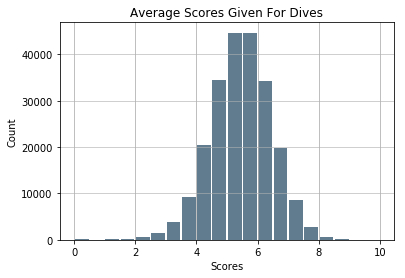

In [18]:
# Generate histogram on diving scores.
data['ave_score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Average Scores Given For Dives')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

The QQPlot shows a normal distribution for most of the data except for the lower range of values.

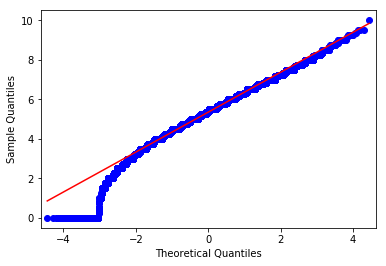

In [19]:
qqplot(data['ave_score'], line='s')
pyplot.show()

We can superimpose a normal curve on top of the data to see how closely it resembles a normal distribution. It is very close but slightly skewed to the right.

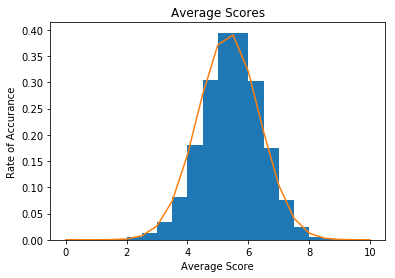

In [20]:
n, bins, patches = plt.hist(data['ave_score'], 20, density=1)
mu = np.mean(data['ave_score'])
sigma = np.std(data['ave_score'])
plt.title('Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Rate of Accurance')
plt.plot(bins, mlab.normpdf(bins, mu, sigma))

In [21]:
# create a different data set for each match condition
# diver and judge team known and not matching
data0 = data[data['same'] == 0]
#data0.head(20)

# diver and judge team known and matching
data1 = data[data['same'] == 1]
#data1.head(20)

# diver and/or judge team not known
data2 = data[data['same'] == 2]
#data2.head(20)

Now we will look at the average scores given based on the team relationship between diver and judge to see if the normal distribution is maintained. These are still roughly normal although not as close to normal as when the data is considered together. This would imply that team affiliations may influence the results.

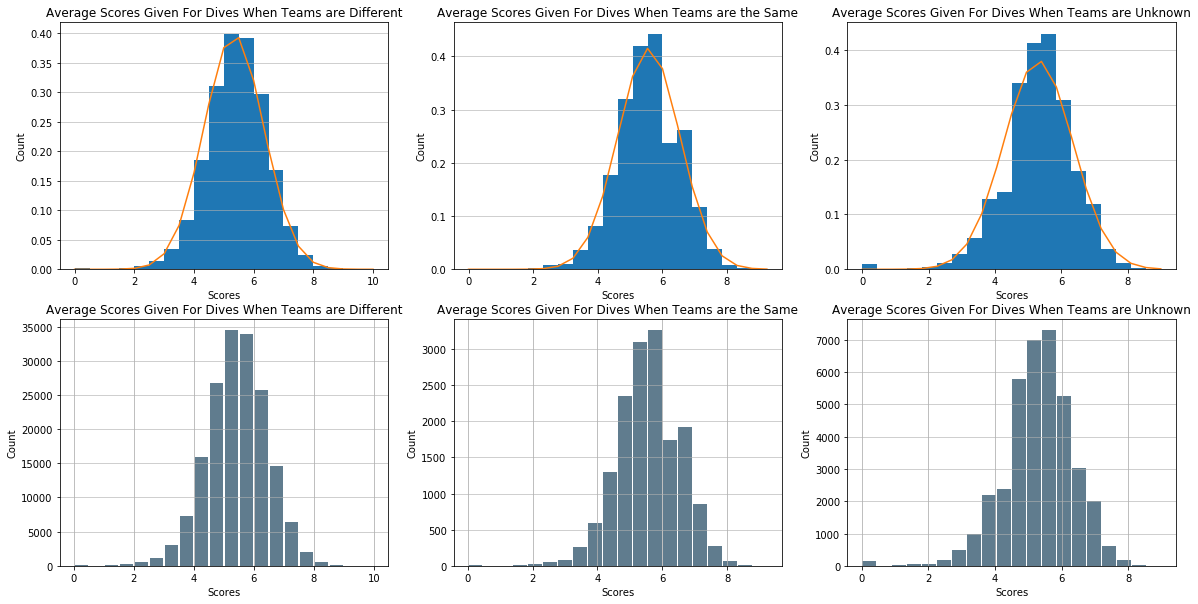

In [22]:
# set up to plot three across
plt.subplots(ncols=3, figsize=(20, 10))

#############################
# histogram plots with normal 
# distribution curve superimposed
# on the data
#############################
# identify the location for this plot
plt.subplot(2,3,1)

n, bins, patches = plt.hist(data0['ave_score'], 20, density=1)
mu = np.mean(data0['ave_score'])
sigma = np.std(data0['ave_score'])
plt.plot(bins, mlab.normpdf(bins, mu, sigma))
# plot the data on diving scores.
plt.title('Average Scores Given For Dives When Teams are Different')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

#--------------------------------
# identify the location for this plot
plt.subplot(2,3,2)

n, bins, patches = plt.hist(data1['ave_score'], 20, density=1)
mu = np.mean(data1['ave_score'])
sigma = np.std(data1['ave_score'])
plt.plot(bins, mlab.normpdf(bins, mu, sigma))
plt.title('Average Scores Given For Dives When Teams are the Same')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

#--------------------------------
# identify the location for this plot
plt.subplot(2,3,3)

n, bins, patches = plt.hist(data2['ave_score'], 20, density=1)
mu = np.mean(data2['ave_score'])
sigma = np.std(data2['ave_score'])
plt.plot(bins, mlab.normpdf(bins, mu, sigma))
plt.title('Average Scores Given For Dives When Teams are Unknown')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)


##################################
# histogram plots plots with only data
##################################
# identify the location for this plot
plt.subplot(2,3,4)

# plot the data on diving scores.
data0['ave_score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Average Scores Given For Dives When Teams are Different')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

#--------------------------------
# identify the location for this plot
plt.subplot(2,3,5)

data1['ave_score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Average Scores Given For Dives When Teams are the Same')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

#--------------------------------
# identify the location for this plot
plt.subplot(2,3,6)

data2['ave_score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Average Scores Given For Dives When Teams are Unknown')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

The histogram plots above indicate that there may be a difference in the distribution of scores based on diver and judge team relationships. Let's look at these score in a boxplot. The boxplots displayed below show that the average of the scores given by judges to divers from the same team is higher than average scores given to divers in the other two categories.

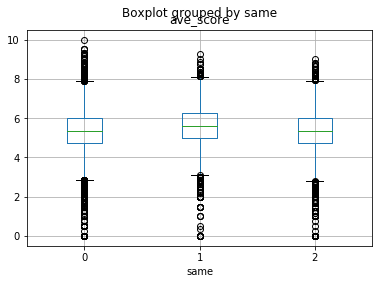

In [23]:
# Let's look at the box plots for the 3 types of scores
data.boxplot(by="same", column="ave_score")

The box plots demonstrate a difference visually. Looking at the statistics for the datasets, we see that the mean average score is 5.338749 when judges and divers are on different teams, 5.588800 when they are on the same teams, and 5.305290 when team affiliation is unknown. The standard deviation is 0.960277 when the teams are the same compared to 1.003949 for different and 1.048141 for unknown team affiliations.

In [24]:
# summary of average scores grouped by same (team affiliation)
rp.summary_cont(data['ave_score'].groupby(data['same']))

,N,Mean,SD,SE,95% Conf.,Interval
same,,,,,,
0,172743,5.338749,1.003949,0.002416,5.334015,5.343484
1,15925,5.588800,0.960277,0.007610,5.573885,5.603715
2,37740,5.305290,1.048141,0.005395,5.294715,5.315865


The mean of the average scores given shows the mean for affiliated judges/coaches (same = 1) to be 0.250051 higher than the mean for non-affiliated judges/coaches (same = 0).

We can use the Analysis of Variance (ANOVA) oneway test to see if there is a statisticaly significant difference between the  three groups. The results with statistic=494.25345493968325 and pvalue=6.541651961874334e-215 indicates that there is a significant difference between one or more of the three groups. 

In [25]:
# one way anova test to determine if there is statistically significant differences between groups
stats.f_oneway(data1.ave_score, data0.ave_score, data2.ave_score)

F_onewayResult(statistic=494.25345493968325, pvalue=6.541651961874334e-215)

We can also use the Levene test to see if our data has equal variance between the groups. We can see from the results that the three groups, different teams, same teams, and unknown teams, do not have equal variance.

In [26]:
# p value shows significance so the groups do not have equal variance
stats.levene(data['ave_score'][data['same'] == 0],
             data['ave_score'][data['same'] == 1],
             data['ave_score'][data['same'] == 2])

LeveneResult(statistic=34.53809576518289, pvalue=1.0059660735485371e-15)

We can use the Tukey HSD post-hoc comparison test to identify which groups have a statistically significant difference between them. "The group1 and group2 columns are the groups being compared, the meandiff column is the difference in means of the two groups being calculated as group2 – group1, the lower/upper columns are the lower/upper boundaries of the 95% confidence interval, and the reject column states whether or not the null hypothesis should be rejected." 
Reference: https://pythonfordatascience.org/anova-python/ Here, each group is statistically different from the other groups. Since group 2 is when team affiliations are unknown, we cannot draw any conclussions using that group. We will concentrate on groups 0 (diver and judge/coach on different teams), and 1 (diver and judge/coach on the same team).

In [27]:
# use the tukey test to determine which groups have a statistically
# significant difference between them.
mc = MultiComparison(data['ave_score'], data['same'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     0.2501   0.2305  0.2696  True 
  0      2    -0.0335  -0.0469  -0.02   True 
  1      2    -0.2835  -0.3058 -0.2612  True 
---------------------------------------------


We can look at a box plot of the scores grouped by event and diver/judge affiliation to see if the pattern holds for all events. 

[Text(0, 0, '11 & Under Girls 3m J.O'),
 Text(0, 0, '12-13 Girls 3m J.O'),
 Text(0, 0, '14-15 Girls 3m J.O'),
 Text(0, 0, '16-18 Girls Platform J.O'),
 Text(0, 0, '11 & Under Boys 1m J.O'),
 Text(0, 0, '12-13 Boys 1m J.O'),
 Text(0, 0, '14-15 Boys 1m  J.O'),
 Text(0, 0, '16-18 Boys Platform J.O'),
 Text(0, 0, '11 & Under Girls 1m J.O'),
 Text(0, 0, '12-13 Girls Platform J.O'),
 Text(0, 0, '14-15 Girls 1m J.O'),
 Text(0, 0, '16-18 Girls 1m J.O'),
 Text(0, 0, '11 & Under Boys 3m J.O'),
 Text(0, 0, '12-13 Boys Platform J.O'),
 Text(0, 0, '14-15 Boys 3m J.O'),
 Text(0, 0, '16-18 Boys 3m J.O'),
 Text(0, 0, '11 & Under Girls Platform J.O'),
 Text(0, 0, '12-13 Girls 1m J.O'),
 Text(0, 0, '14-15 Girls Platform J.O'),
 Text(0, 0, '16-18 Girls 3m J.O'),
 Text(0, 0, '11 & Under Boys Platform J.O'),
 Text(0, 0, '12-13 Boys 3m J.O'),
 Text(0, 0, '14-15 Boys Platform J.O'),
 Text(0, 0, '16-18 Boys 1m J.O')]

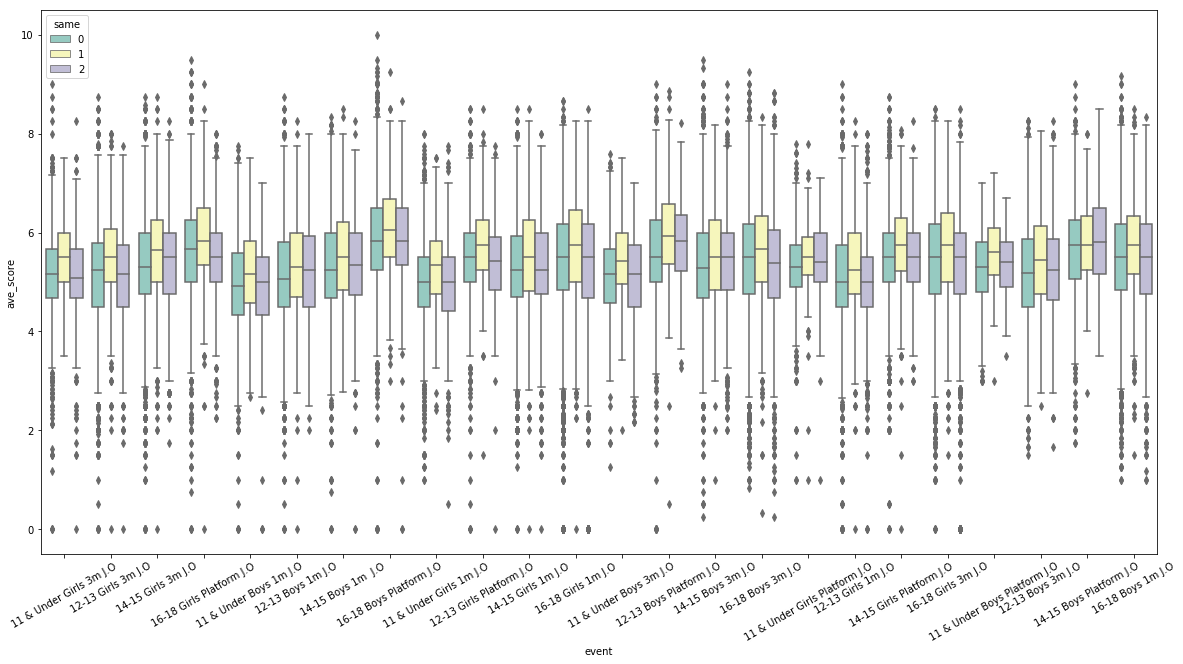

In [28]:
# We can make this better
plt.rcParams["figure.figsize"] = (20,10)

#sns.boxplot(x=data["same"], y=data["ave_score"], palette="Blues", title = "Average Score Comparison")
ax = sns.boxplot(x="event", y="ave_score", hue="same",
                 data=data, palette="Set3")
ax.set_xticklabels(rotation=30, labels=data.event.unique())

We can see that for all events, the average of scores given by judges to divers on their same team is higher than the average of scores given to divers on different teams. The scores given by  judges to divers on their same team is higher than the average of scores given by judges to divers when team affiliations are unknown in all but two events.

The histogram plot of average scores for diver and judge on the same team vs diver and judge on different teams shows an interesting pattern where a higher percentage of the scores below the mean are given by judges from different teams and a higher percentage of the scores above the mean are given by judges from the same team. The p-value less than 0.05 indicates that the difference in avereage scores given is statistically significant. <br><br>
The question arises as to whether the difference in scoring is similar for different groupings of the data. Is there more likely to be bias for the older divers who are looking to perform well to secure college scholarships? Divers getting NCAA scholarships look good for coaches and help them attract younger divers hoping for similar success. 

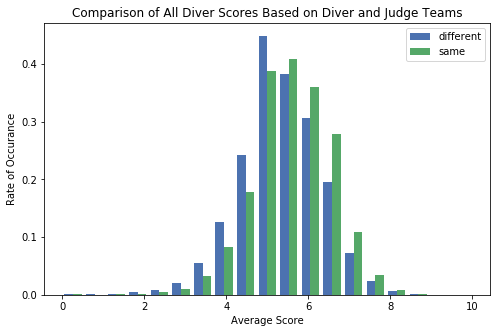

t = -30.183745197366047
p = 1.1615437658543445e-199


In [29]:
plt.rcParams["figure.figsize"] = (8,5)

plt.style.use('seaborn-deep')

x = data0['ave_score']
y = data1['ave_score']
bins = np.linspace(0, 10, 20)

plt.hist([x, y], bins, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of All Diver Scores Based on Diver and Judge Teams')
plt.xlabel('Average Score')
plt.ylabel('Rate of Occurance')
plt.show()

t2, p2 = stats.ttest_ind(x, y)
print("t = " + str(t2))
print("p = " + str(p2))

We can look at the scores separated by event. There are 24 different events. Are there any events where the difference is scores given is not significant? The events include data from all meets although not all events were competed at all meets. Several of the regional meets did not compete the platform events.

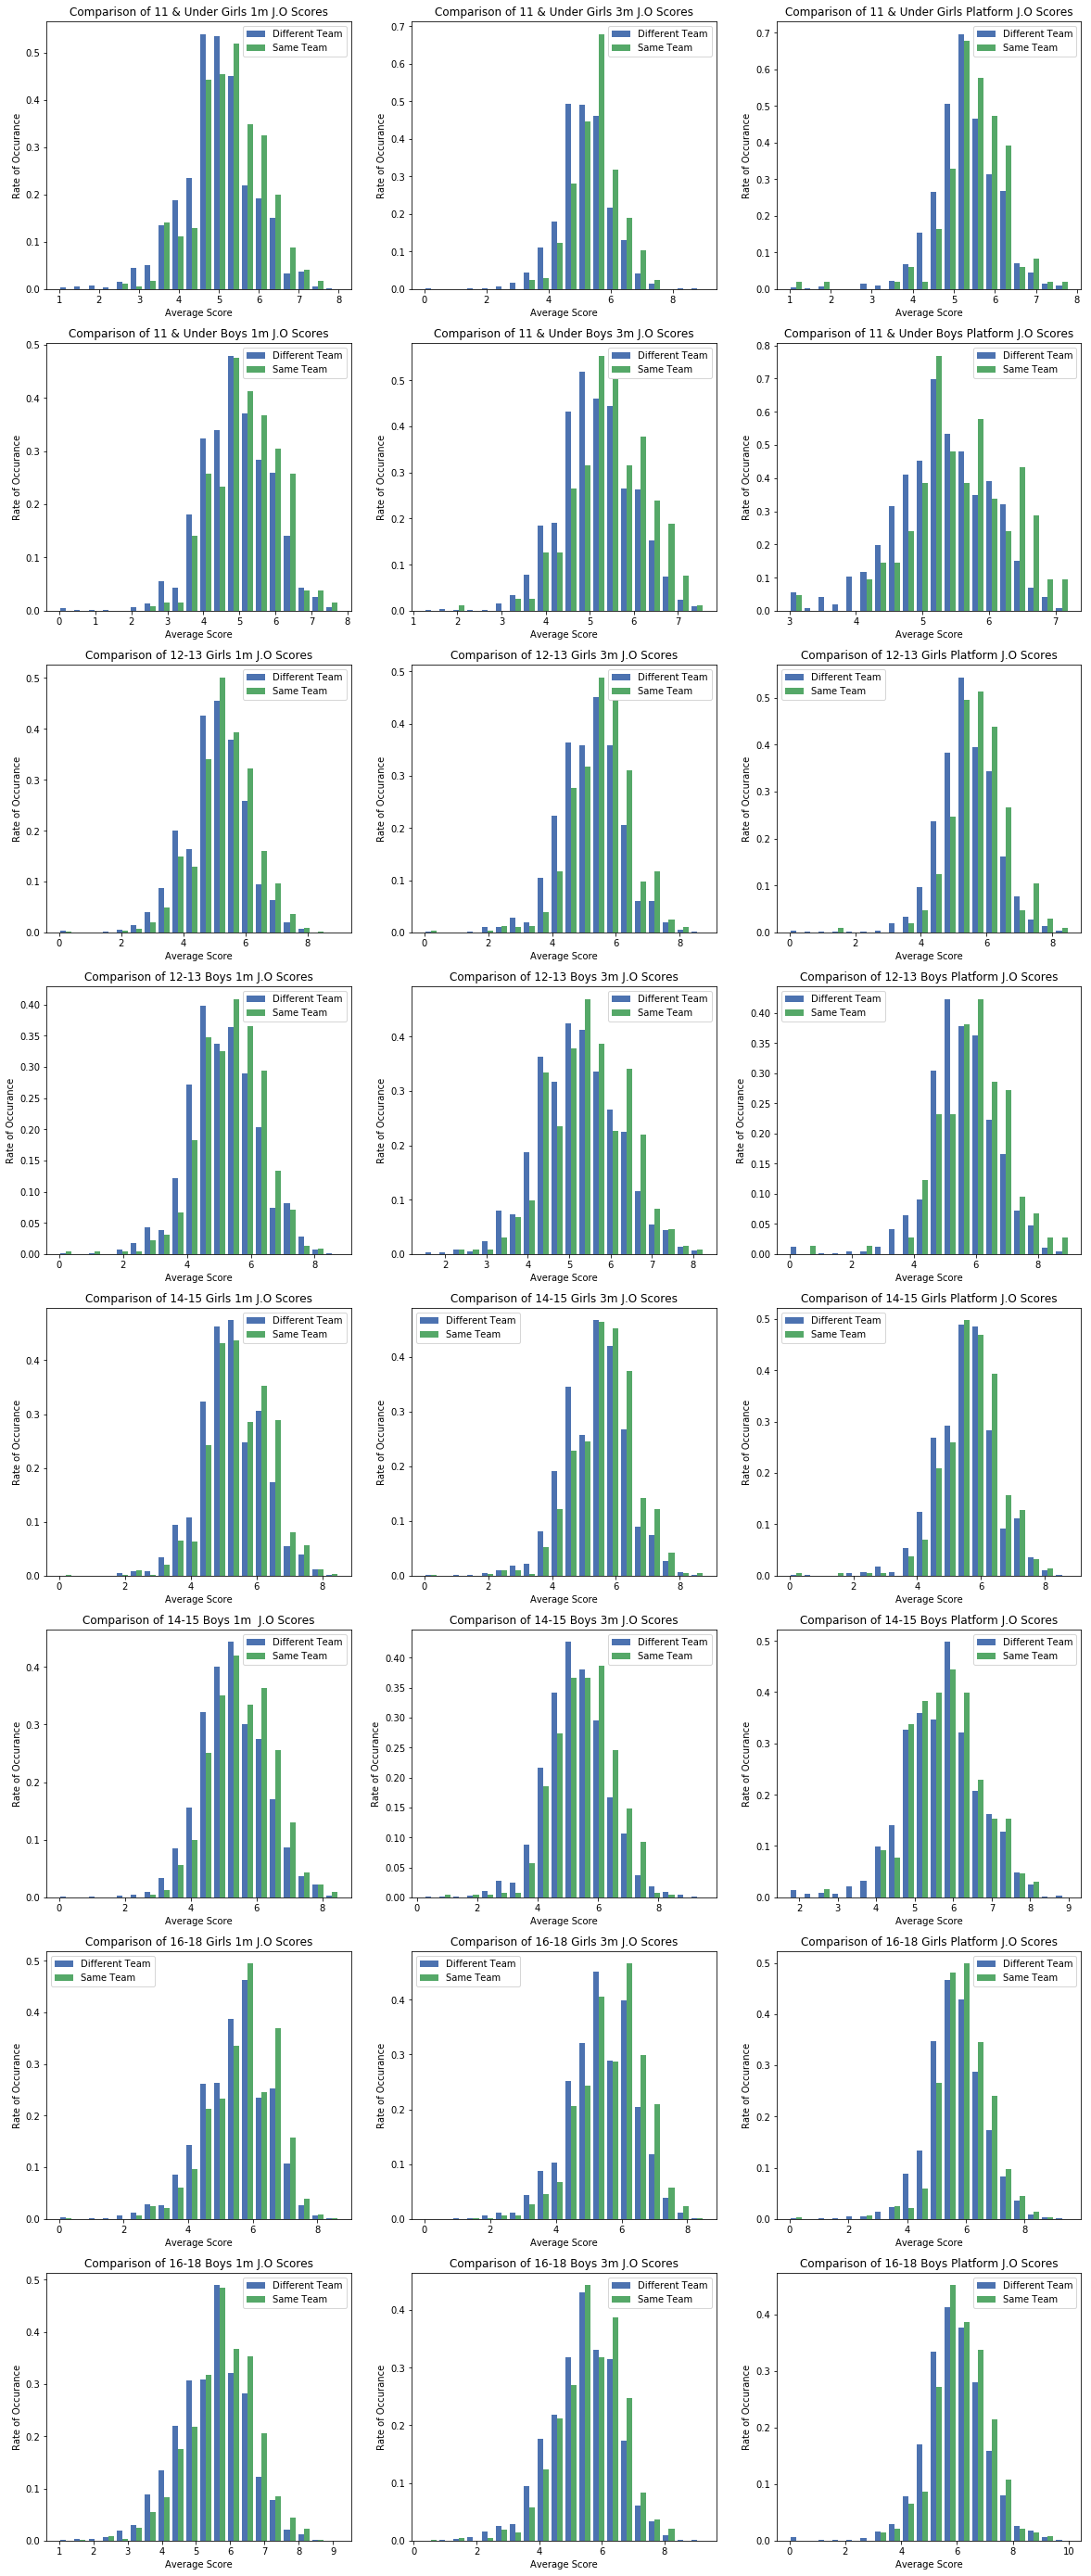

In [30]:
# define list of the 24 different events in the meets
# used for looping through data to separate results by event
event_list = ['11 & Under Girls 1m J.O', '11 & Under Girls 3m J.O', '11 & Under Girls Platform J.O', 
              '11 & Under Boys 1m J.O', '11 & Under Boys 3m J.O', '11 & Under Boys Platform J.O',
              '12-13 Girls 1m J.O', '12-13 Girls 3m J.O', '12-13 Girls Platform J.O',
              '12-13 Boys 1m J.O', '12-13 Boys 3m J.O', '12-13 Boys Platform J.O',
              '14-15 Girls 1m J.O', '14-15 Girls 3m J.O', '14-15 Girls Platform J.O',
              '14-15 Boys 1m  J.O', '14-15 Boys 3m J.O', '14-15 Boys Platform J.O',
              '16-18 Girls 1m J.O', '16-18 Girls 3m J.O', '16-18 Girls Platform J.O',
              '16-18 Boys 1m J.O', '16-18 Boys 3m J.O', '16-18 Boys Platform J.O',]

# assign colors for the two different team affiliations
colors = ['#E69F00', '#56B4E9']
names = ['Different Team','Same Team']

# define data frame for storing analysis values
event_df = pd.DataFrame(columns=['Event', 'Different', 'Same', 't value', 'p value'])

#%matplotlib inline

# set up for plotting three across
plt.subplots(ncols=3, figsize=(20, 50))
plt.style.use('seaborn-deep')

# define index for plot placement
i = 0
  
for event in event_list:
    
    i = i + 1
   
    # Make a separate list of scores for each event
    x1 = list(data0[data0['event'] == event]['ave_score'])
    x2 = list(data1[data1['event'] == event]['ave_score'])

    #print('Different records = ', len(x1), ' Same records = ', len(x2))
    
    # Find the right spot on the plot grid
    plt.subplot(8,3,i)
    
    # Make the histogram using the lists
    # Normalize the scores and assign colors and names
    plt.hist([x1, x2], bins = 20, density=True, label=names)
    #         color = colors, label=names)

    # Plot formatting
    plt.legend()
    plt.xlabel('Average Score')
    plt.ylabel('Rate of Occurance')
    plt.title('Comparison of ' + event + ' Scores')

    t, p = stats.ttest_ind(x1, x2)
    event_df = event_df.append({'Event': event, 'Different': len(x1), 'Same': len(x2), 't value': t, 'p value' : p}, 
                           ignore_index=True)
    


In [31]:
print (event_df)

                            Event Different  Same    t value       p value
0         11 & Under Girls 1m J.O      4629   484  -7.023440  2.448098e-12
1         11 & Under Girls 3m J.O      3218   363  -7.465318  1.037957e-13
2   11 & Under Girls Platform J.O      1132   143  -3.000260  2.749957e-03
3          11 & Under Boys 1m J.O      2794   331  -5.119264  3.253036e-07
4          11 & Under Boys 3m J.O      1751   251  -5.471219  5.030456e-08
5    11 & Under Boys Platform J.O       695    99  -3.697205  2.330153e-04
6              12-13 Girls 1m J.O     12188  1032  -7.910476  2.767005e-15
7              12-13 Girls 3m J.O      9661   898  -9.554282  1.520697e-21
8        12-13 Girls Platform J.O      2577   247  -5.440502  5.768380e-08
9               12-13 Boys 1m J.O      5572   514  -4.568538  5.008295e-06
10              12-13 Boys 3m J.O      3758   391  -4.661127  3.243608e-06
11        12-13 Boys Platform J.O      1500   163  -3.850868  1.221672e-04
12             14-15 Girl

The results displayed above contain the event name, the count of average scores given by judges/coaches from different teams than the diver, the count of average score given by judges/coaches on the same team as the diver, the t value, and the p value. These results indicate that a statistically significant difference exists for the average scores given across all age groups and events. Looking at the p values for the data, the only event where the difference in average scores given is not significant is for 14-15 Boys Platform. Since all the other events show a significant difference, why does this one not? This would take some external, manual evaluation of the data. The platform events usually have fewer divers competing and there are even instances where there are few enough divers that all competing will advance to the next meet. In those cases, there is less incentive for bias in the scoring. Later in the analysis, the scores will be looked at individually instead of using an average of the scores given. We will revisit the results for this event to see if they are the same. <br>

The data can also be grouped by region. There are 12 different regions across the United States. Is it possible that there is one region with significant bias in scoring that is affecting the results?

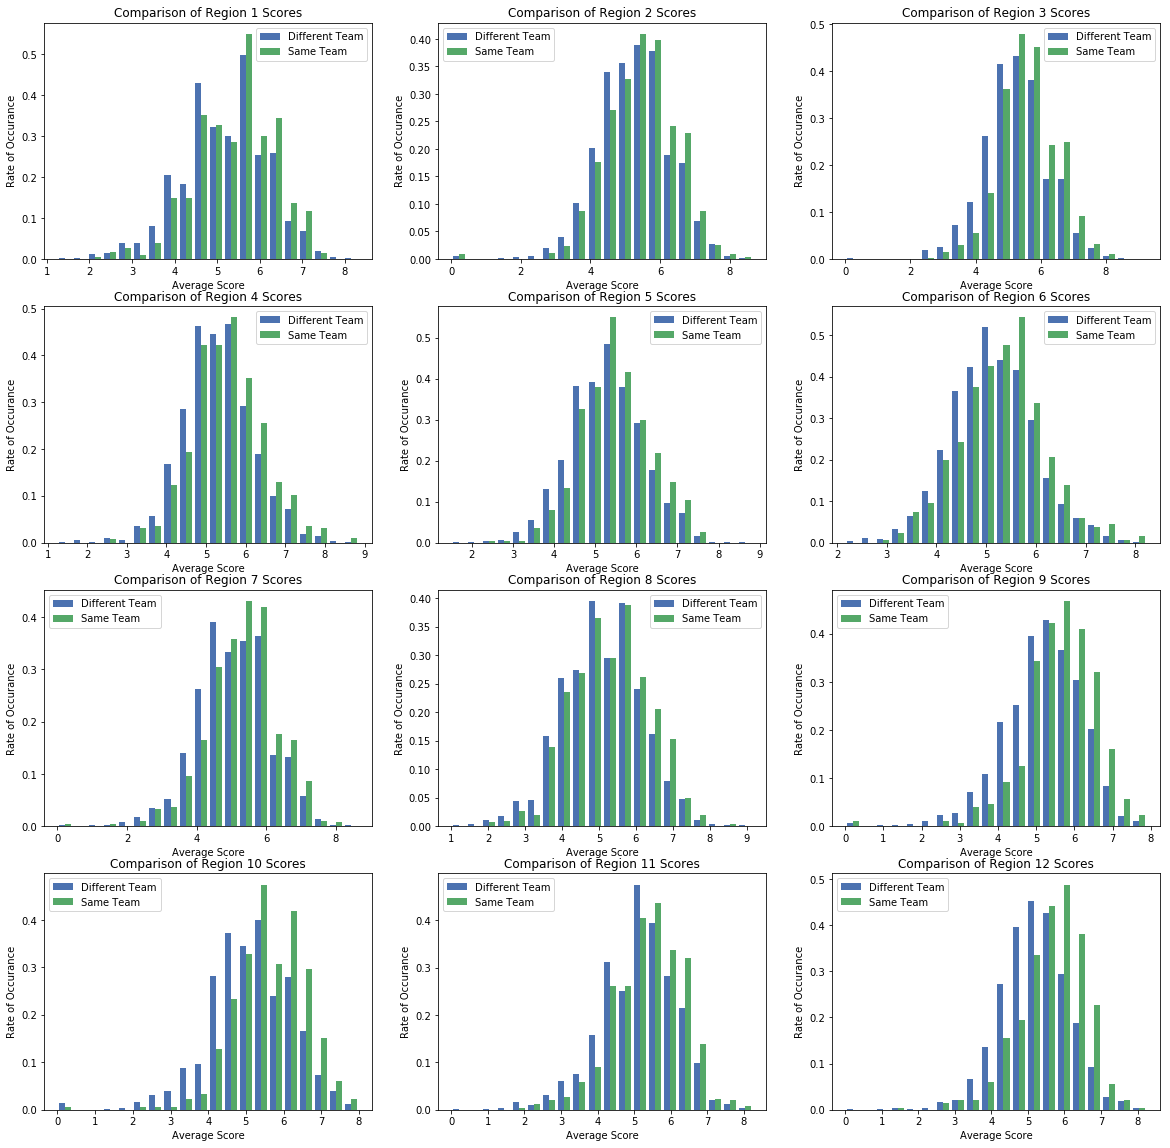

In [32]:
# define list of the 12 different regions 
# used for looping through data to separate results by region
region_list = ["Region 1", "Region 2", "Region 3", "Region 4",
               "Region 5", "Region 6", "Region 7", "Region 8",
               "Region 9", "Region 10", "Region 11", "Region 12"]

# set up for plotting three across
plt.subplots(ncols=3, figsize=(20, 20))
plt.style.use('seaborn-deep')

# define data frame for storing analysis values
reg_df = pd.DataFrame(columns=['Region', 'Different', 'Same', 't value', 'p value'])
  
# define index for plot placement
i = 0
  
for region in region_list:
    
    i = i + 1
   
    # Make a separate list of scores for each event
    x1 = list(data0[data0['meet'] == region]['ave_score'])
    x2 = list(data1[data1['meet'] == region]['ave_score'])

    #print('Different records = ', len(x1), ' Same records = ', len(x2))
    
    # Find the right spot on the plot grid
    plt.subplot(4,3,i)
    
    # Make the histogram using the lists
    # Normalize the scores and assign colors and names
    plt.hist([x1, x2], bins = 20, density=True, label=names)
    #         color = colors, label=names)

    # Plot formatting
    plt.legend()
    plt.xlabel('Average Score')
    plt.ylabel('Rate of Occurance')
    plt.title('Comparison of ' + region + ' Scores')

    t, p = stats.ttest_ind(x1, x2)
    reg_df = reg_df.append({'Region': region, 'Different': len(x1), 'Same': len(x2), 't value': t, 'p value' : p}, 
                           ignore_index=True)
    


In [33]:
print(reg_df)

       Region Different Same    t value       p value
0    Region 1     10273  949  -6.539919  6.422702e-11
1    Region 2      7766  795  -4.462548  8.202645e-06
2    Region 3      8490  748  -8.618942  7.871298e-18
3    Region 4      4497  749  -6.144979  8.587569e-10
4    Region 5      5052  759  -5.156060  2.605499e-07
5    Region 6      2531  450  -4.147074  3.461566e-05
6    Region 7      6414  643  -5.121041  3.119000e-07
7    Region 8      9417  738  -4.495893  7.004641e-06
8    Region 9      2856  444  -8.082342  8.828682e-16
9   Region 10      4900  448  -9.463751  4.341019e-21
10  Region 11      6748  612  -5.776728  7.927235e-09
11  Region 12      5540  686 -12.130797  1.727984e-33


The results displayed above contain the region, the count of average scores given by judges/coaches from different teams than the diver, the count of average score given by judges/coaches on the same team as the diver, the t value, and the p value. The plots and the p values again show that the bias exists across all regions. The results for the regional meets does not include data from the zone meets. The top divers from the regional meets move on to the zone meets. The zone meets are a combination of two of the regions. Regions 1 and 2 compete at the Zone A meet, 3 and 4 at Zone B, 5 and 6 at Zone C, 7 and 8 at Zone D, 9 and 10 at Zone E, and 11 and 12 at Zone F. Not all teams competing at a regional meet will have divers that advance to a zone meet so some judges at regional meets will not be present at zone meets. Will that make a difference in the results? If there was bias at the regional meet, there will likely be bias at the corresponding zone meet. We can look at the results to see if this is the case.

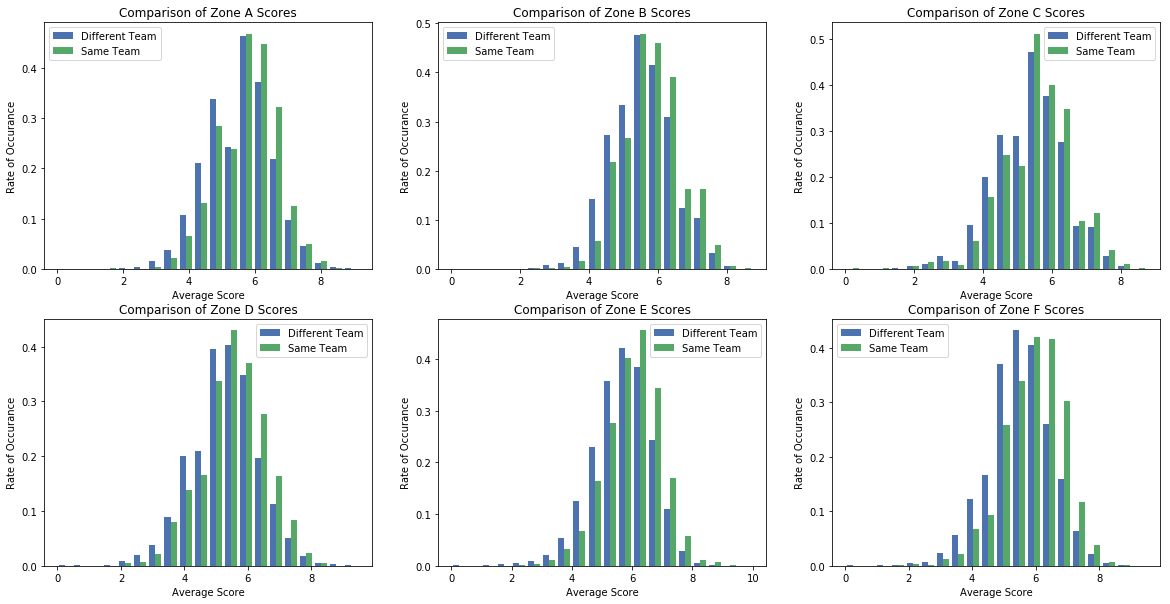

In [34]:
# define list of the 6 different zone 
# used for looping through data to separate results by zone
zone_list = ["Zone A", "Zone B", "Zone C",
             "Zone D", "Zone E", "Zone F"]

# set up for plotting three across
plt.subplots(ncols=3, figsize=(20, 10))
plt.style.use('seaborn-deep')

# define data frame for storing analysis values
zone_df = pd.DataFrame(columns=['Zone', 'Different', 'Same', 't value', 'p value'])
 
# define index for plot placement
i = 0

for zone in zone_list:
    
    i = i + 1
   
    # Make a separate list of scores for each event
    x1 = list(data0[data0['meet'] == zone]['ave_score'])
    x2 = list(data1[data1['meet'] == zone]['ave_score'])

    #print('Different records = ', len(x1), ' Same records = ', len(x2))
    
    # Find the right spot on the plot grid
    plt.subplot(2,3,i)
    
    # Make the histogram using the lists
    # Normalize the scores and assign colors and names
    plt.hist([x1, x2], bins = 20, density=True, label=names)
    #         color = colors, label=names)

    # Plot formatting
    plt.legend()
    plt.xlabel('Average Score')
    plt.ylabel('Rate of Occurance')
    plt.title('Comparison of ' + zone + ' Scores')

    t, p = stats.ttest_ind(x1, x2)
    zone_df = zone_df.append({'Zone': zone, 'Different': len(x1), 'Same': len(x2), 't value': t, 'p value' : p}, 
                           ignore_index=True)
    


In [35]:
print(zone_df)

     Zone Different  Same    t value       p value
0  Zone A     22608  1679  -9.309574  1.388841e-20
1  Zone B     12611   923  -8.275216  1.401375e-16
2  Zone C     17676  1730  -6.829915  8.748095e-12
3  Zone D     14122   912  -6.574315  5.048893e-11
4  Zone E     13029  1548 -12.007986  4.620268e-33
5  Zone F     18213  1112 -13.156844  2.295485e-39


The results displayed above contain the zone, the count of average scores given by judges/coaches from different teams than the diver, the count of average score given by judges/coaches on the same team as the diver, the t value, and the p value. Here again, looking at the histograms and the p value, we see that there is bias for all zones at a statistically significant level.

We can look at zone and regional meet data together but separated by year. Was there any year where there was no bias?

In [36]:
# build datasets for each year
yr2016 = data[data['year'].str.contains("2016")] 
yr2017 = data[data['year'].str.contains("2017")] 
yr2018 = data[data['year'].str.contains("2018")] 

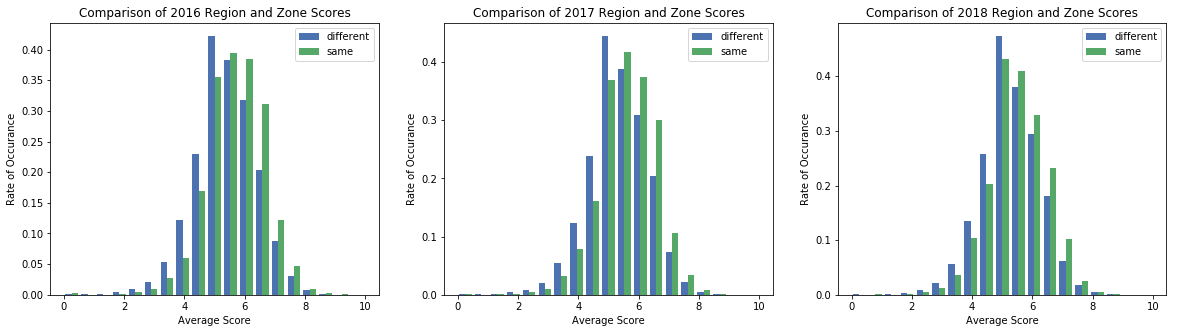

In [37]:
# set up for plotting three across
plt.subplots(ncols=3, figsize=(20, 5))
plt.style.use('seaborn-deep')
bins = np.linspace(0, 10, 20)

# define data frame for storing analysis values
year_df = pd.DataFrame(columns=['Year', 'Different', 'Same', 't value', 'p value'])


####################
# 2016 Scores
####################

plt.subplot(1,3,1)

yrdata0 = yr2016[yr2016['same'] == 0]
yrdata1 = yr2016[yr2016['same'] == 1]

x = yrdata0['ave_score']
y = yrdata1['ave_score']

plt.hist([x, y], bins, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of 2016 Region and Zone Scores')
plt.xlabel('Average Score')
plt.ylabel('Rate of Occurance')

t, p = stats.ttest_ind(x, y)
year_df = year_df.append({'Year': '2016', 'Different': len(x), 'Same': len(y), 't value': t, 'p value' : p}, 
                           ignore_index=True)

####################
# 2017 Scores
####################

plt.subplot(1,3,2)

yrdata0 = yr2017[yr2017['same'] == 0]
yrdata1 = yr2017[yr2017['same'] == 1]

x = yrdata0['ave_score']
y = yrdata1['ave_score']

plt.hist([x, y], bins, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of 2017 Region and Zone Scores')
plt.xlabel('Average Score')
plt.ylabel('Rate of Occurance')

t, p = stats.ttest_ind(x, y)
year_df = year_df.append({'Year': '2017', 'Different': len(x), 'Same': len(y), 't value': t, 'p value' : p}, 
                           ignore_index=True)

####################
# 2018 Scores
####################

plt.subplot(1,3,3)

yrdata0 = yr2018[yr2018['same'] == 0]
yrdata1 = yr2018[yr2018['same'] == 1]

x = yrdata0['ave_score']
y = yrdata1['ave_score']

plt.hist([x, y], bins, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of 2018 Region and Zone Scores')
plt.xlabel('Average Score')
plt.ylabel('Rate of Occurance')

t, p = stats.ttest_ind(x, y)
year_df = year_df.append({'Year': '2018', 'Different': len(x), 'Same': len(y), 't value': t, 'p value' : p}, 
                           ignore_index=True)


In [38]:
print (year_df)

   Year Different  Same    t value       p value
0  2016     49794  4479 -18.313777  1.079833e-74
1  2017     60622  5727 -19.218201  4.361863e-82
2  2018     62327  5719 -14.908327  3.492847e-50


The results displayed above contain the year, the count of average scores given by judges/coaches from different teams than the diver, the count of average score given by judges/coaches on the same team as the diver, the t value, and the p value. The histograms and the p values again show that there is bias for all years.

#### Data Exploration and Analysis Using Raw Scores
We will now run the whole analysis again with each individual score instead of using an average of the scores given. The original 226,408 records will be split into a single record for each score given. This results in 826,765 records. The record for each score will also contain the appropriate affiliation flag.<br>
The separation of the data into individual records was done by a separate program outside of Jupyter Notebook which ran much faster than it would have inside the notebook. The data file is read in here for analysis. There is no need for the score1 to score11 fields since each records contains only one score. A check for the range of values for the score field shows the range as 0 to 10. This is correct so there are no issues with this variable.

In [39]:
# reading csv file from containing divemeets data and assign headers  
scores_df = pd.read_csv("divemeets_scores_data.csv") 
scores_df.head(20)
scores_df.info()
print (scores_df.describe().transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826765 entries, 0 to 826764
Data columns (total 4 columns):
meet     826765 non-null object
event    826765 non-null object
score    826765 non-null float64
same     826765 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 25.2+ MB
          count      mean       std  min  25%  50%  75%   max
score  826765.0  5.353494  1.299852  0.0  4.5  5.5  6.0  10.0
same   826765.0  0.430451  0.772495  0.0  0.0  0.0  1.0   2.0


In [40]:
# Remove the (Opt.1st) from the events where the cut option is used
scores_df['event'] = scores_df['event'].str.replace(r" \(.*\)","")
#scores_df.event.unique()
#print (scores_df.describe().transpose())

In [41]:
# meet field contains year and meet name
# create a new data frame with split value columns 
new = scores_df["meet"].str.split(" USA Diving ", n = 1, expand = True) 
  
# make a separate year column from new data frame 
scores_df["year"]= new[0] 
  
# write over the old meet name column with the separated meet name 
scores_df["meet"]= new[1] 

# Remove extra words from the meet name
scores_df['meet'] = scores_df['meet'].str.replace(r" Championships","")
scores_df['meet'] = scores_df['meet'].str.replace(r"Junior ","")
scores_df['meet'] = scores_df['meet'].str.replace(r"National ","")
scores_df['meet'] = scores_df['meet'].str.replace(r"Preliminary ","")
scores_df['meet'] = scores_df['meet'].str.replace(r" Meet","")
  
# Look at file to confirm changes.
#scores_df.tail(25)
#scores_df.head(25)


The file structure for this section of analysis looks as follows:

In [42]:
scores_df.tail(10)

,meet,event,score,same,year
826755,Zone F,16-18 Boys Platform J.O,5.5,0,2018
826756,Zone F,16-18 Boys Platform J.O,5.0,0,2018
826757,Zone F,16-18 Boys Platform J.O,5.0,0,2018
826758,Zone F,16-18 Boys Platform J.O,6.0,0,2018
826759,Zone F,16-18 Boys Platform J.O,4.0,0,2018
826760,Zone F,16-18 Boys Platform J.O,7.0,0,2018
826761,Zone F,16-18 Boys Platform J.O,5.5,0,2018
826762,Zone F,16-18 Boys Platform J.O,4.0,0,2018
826763,Zone F,16-18 Boys Platform J.O,6.0,0,2018
826764,Zone F,16-18 Boys Platform J.O,4.0,0,2018


When the distribution of the raw scores is compared to the distribution of the average scores, it can be seen that the raw scores plot displays more data records on the extremes, has a less normal distribution, and the mean and mode appear to occur at a higher value. This is to be expected as using averages tends to smooth and normalize the data.

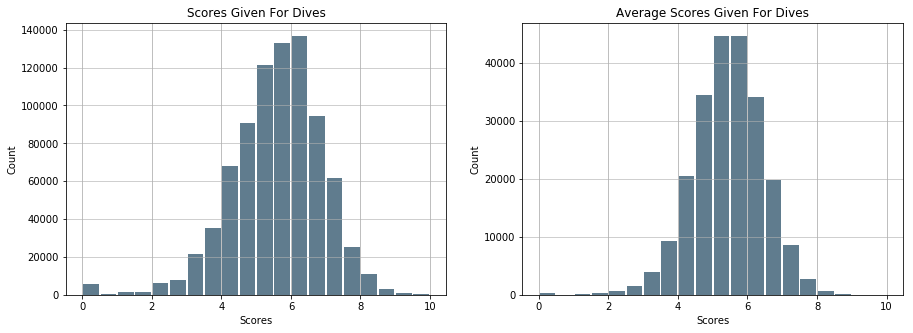

In [ ]:
#data = scores_df
# set up to plot three across
plt.subplots(ncols=2, figsize=(15, 5))

# identify the location for this plot
plt.subplot(1,2,1)

# Generate histogram on diving scores.
scores_df['score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Scores Given For Dives')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

# identify the location for this plot
plt.subplot(1,2,2)

data['ave_score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Average Scores Given For Dives')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)


Looking at the histogram with a normal distribution superimposed, we again see that the distribution is close to normal except for the values on the ends, however it has a less normal distribution than the average score data analyzed above. The raw score histogram is skewed to the right, towards higher scores, and also has a higher number of 0's occurring than would be expected in a perfectly normal distribution. Scores are limited to the range of 0 to 10 and occurrances of 10 are very rare. The increased occurance of 0 scores is because it is more likely that a diver would fail the dive completely and receive a zero score than complete the dive so poorly as to receive a score of 0.5 to 1.5. Occurrances of scores less than 2 are rare but not as rare as coaches would like nor as rare as scores greater than 9.0.

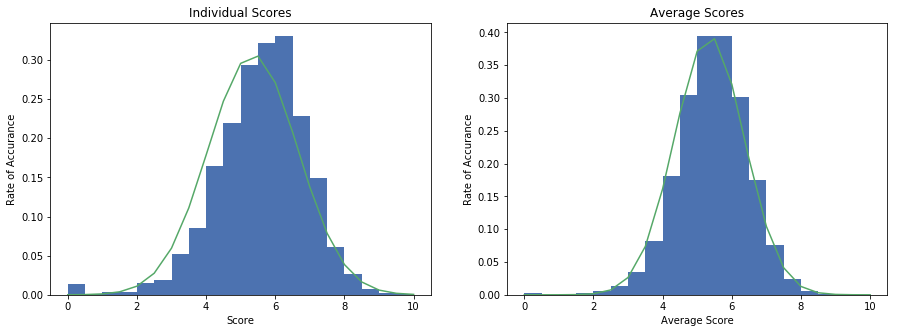

In [ ]:
#data = scores_df
# set up to plot two across
plt.subplots(ncols=2, figsize=(15, 5))

# identify the location for this plot
plt.subplot(1,2,1)
n, bins, patches = plt.hist(scores_df['score'], 20, density=1)
mu = np.mean(scores_df['score'])
sigma = np.std(scores_df['score'])
plt.title('Individual Scores')
plt.xlabel('Score')
plt.ylabel('Rate of Accurance')
plt.plot(bins, mlab.normpdf(bins, mu, sigma))

# identify the location for this plot
plt.subplot(1,2,2)
n, bins, patches = plt.hist(data['ave_score'], 20, density=1)
mu = np.mean(data['ave_score'])
sigma = np.std(data['ave_score'])
plt.title('Average Scores')
plt.xlabel('Average Score')
plt.ylabel('Rate of Accurance')
plt.plot(bins, mlab.normpdf(bins, mu, sigma))


The QQPlot also shows that the distribution is close to normal except for the values on the ends. The values for the raw scores are stair-stepped since scores are only given in increments of 0.5 as opposed to the averages of scores given which can be continuous.

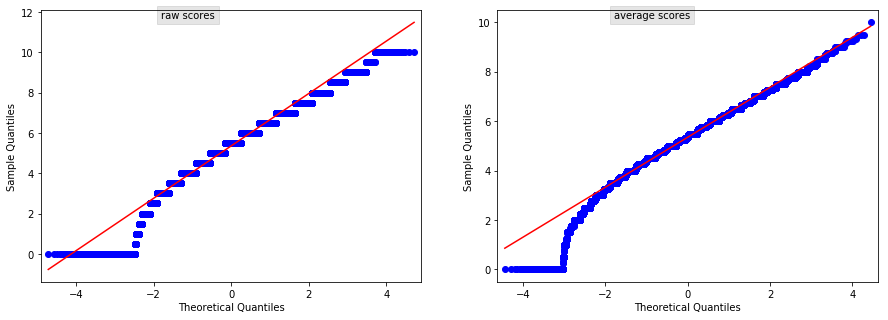

In [ ]:
left = -1.8   #x coordinate for text insert
# set size of figure display
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 2, 1)
sm.graphics.qqplot(scores_df['score'], line='s', ax=ax)
top = ax.get_ylim()[1] 
txt = ax.text(left, top, 'raw scores', verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

ax = fig.add_subplot(1, 2, 2)
sm.graphics.qqplot(data['ave_score'], line='s', ax=ax)
top = ax.get_ylim()[1] 
txt = ax.text(left, top, "average scores", verticalalignment='top')
txt.set_bbox(dict(facecolor='k', alpha=0.1))

Several tests for normality were run on both the data for average scores given and the raw scores. All failed the normality tests because of the sample size. Below are the results for the raw data using several normality tests. This is included for completeness.

In [ ]:
stat, p = shapiro(scores_df['score'])
print('Shapiro test - Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')
    
    
stat, p = normaltest(scores_df['score'])
print('Normal test - Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')
    
    
from scipy.stats import anderson
result = anderson(scores_df['score'])
print('Anderson test - Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal' % (sl, cv))

Shapiro test - Statistics=0.965, p=0.000
Sample does not look Gaussian
Normal test - Statistics=76857.859, p=0.000
Sample does not look Gaussian
Anderson test - Statistic: 7744.033
15.000: 0.576, data does not look normal
10.000: 0.656, data does not look normal
5.000: 0.787, data does not look normal
2.500: 0.918, data does not look normal
1.000: 1.092, data does not look normal


In [ ]:
# create a different data set for each match condition
# diver and judge team known and not matching
sdata0 = scores_df[scores_df['same'] == 0]
#sdata0.head(20)

# diver and judge team known and matching
sdata1 = scores_df[scores_df['same'] == 1]
#sdata1.head(20)

# diver and/or judge team not known
sdata2 = scores_df[scores_df['same'] == 2]

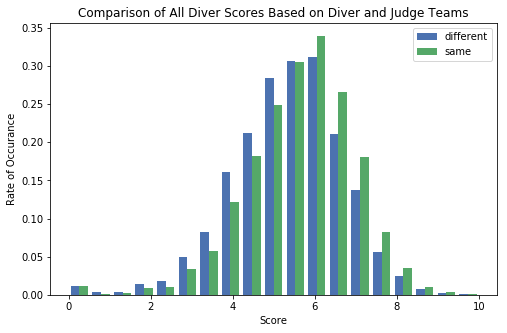

t = -47.81972103816645
p = 0.0


In [ ]:
plt.rcParams["figure.figsize"] = (8,5)

plt.style.use('seaborn-deep')

sx = sdata0['score']
sy = sdata1['score']
bins = np.linspace(0, 10, 20)

plt.hist([sx, sy], bins, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of All Diver Scores Based on Diver and Judge Teams')
plt.xlabel('Score')
plt.ylabel('Rate of Occurance')
plt.show()

t2, p2 = stats.ttest_ind(sx, sy)
print("t = " + str(t2))
print("p = " + str(p2))

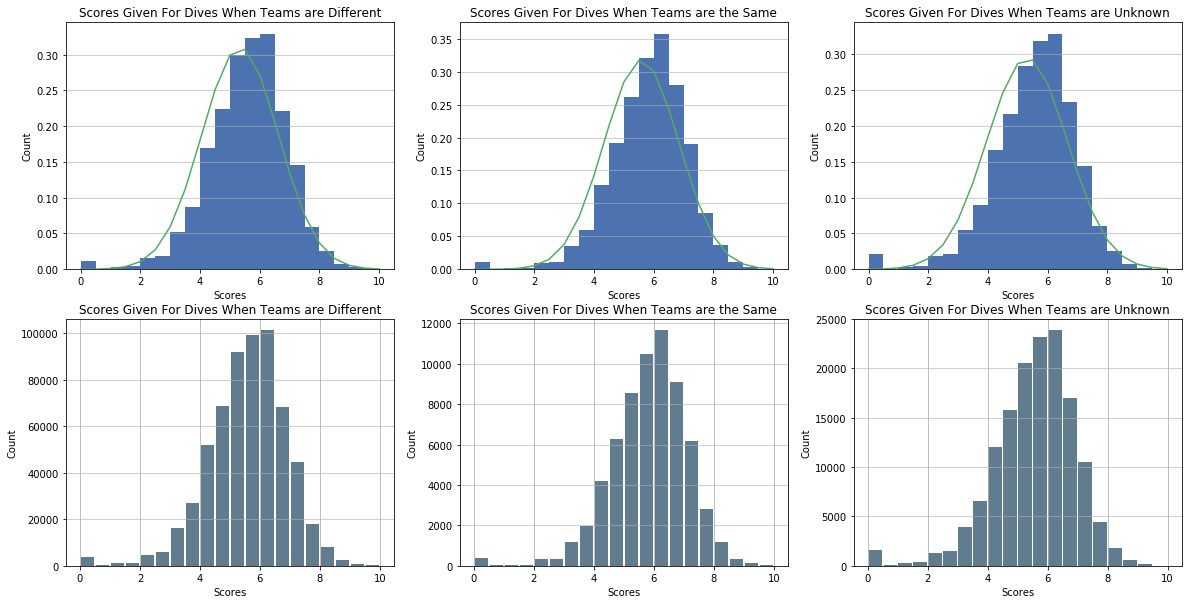

In [ ]:
# set up for plots three across
plt.subplots(ncols=3, figsize=(20, 10))

#############################
# histogram plots with normal 
# distribution curve superimposed
# on the data
#############################
# identify the location for this plot
plt.subplot(2,3,1)

n, bins, patches = plt.hist(sdata0['score'], 20, density=1)
mu = np.mean(sdata0['score'])
sigma = np.std(sdata0['score'])
plt.plot(bins, mlab.normpdf(bins, mu, sigma))
# plot the data on diving scores.
plt.title('Scores Given For Dives When Teams are Different')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

#--------------------------------
# identify the location for this plot
plt.subplot(2,3,2)

n, bins, patches = plt.hist(sdata1['score'], 20, density=1)
mu = np.mean(sdata1['score'])
sigma = np.std(sdata1['score'])
plt.plot(bins, mlab.normpdf(bins, mu, sigma))
plt.title('Scores Given For Dives When Teams are the Same')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

#--------------------------------
# identify the location for this plot
plt.subplot(2,3,3)

n, bins, patches = plt.hist(sdata2['score'], 20, density=1)
mu = np.mean(sdata2['score'])
sigma = np.std(sdata2['score'])
plt.plot(bins, mlab.normpdf(bins, mu, sigma))
plt.title('Scores Given For Dives When Teams are Unknown')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)


##################################
# histogram plots plots with only data
##################################
# identify the location for this plot
plt.subplot(2,3,4)

# plot the data on diving scores.
sdata0['score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Scores Given For Dives When Teams are Different')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

#--------------------------------
# identify the location for this plot
plt.subplot(2,3,5)

sdata1['score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Scores Given For Dives When Teams are the Same')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

#--------------------------------
# identify the location for this plot
plt.subplot(2,3,6)

sdata2['score'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Scores Given For Dives When Teams are Unknown')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

In [ ]:
rp.summary_cont(scores_df['score'].groupby(scores_df['same']))

,N,Mean,SD,SE,95% Conf.,Interval
same,,,,,,
0,616222,5.338323,1.288394,0.001641,5.335106,5.341540
1,65204,5.591444,1.256085,0.004919,5.581802,5.601085
2,145339,5.311066,1.355501,0.003556,5.304097,5.318035


The mean of the scores given by affiliated judges/coaches (same = 1) is 0.253121 higher than the mean for non-affiliated judges/coaches (same = 0). This is greater than the 0.250051 difference found when considering only averages of the scores given. This is a more correct measure of possible bias because it is giving equal weight to each score given rather than averaging a variable number of scores.

We can use the Analysis of Variance (ANOVA) oneway test to see if there is a statisticaly significant difference between the  three groups. The results with statistic=494.25345493968325 and pvalue=6.541651961874334e-215 indicates that there is a significant difference between one or more of the three groups. 

In [ ]:
# one way anova test to determine if there is statistically significant differences between groups
stats.f_oneway(sdata1.score, sdata0.score, sdata2.score)

F_onewayResult(statistic=1215.4692384408672, pvalue=0.0)

We can also use the Levene test to see if our data has equal variance between the groups. We can see from the results that the three groups, different teams, same teams, and unknown teams, do not have equal variance. 

In [ ]:
# p value shows significance so the groups do not have equal variance
stats.levene(scores_df['score'][scores_df['same'] == 0],
             scores_df['score'][scores_df['same'] == 1],
             scores_df['score'][scores_df['same'] == 2])

LeveneResult(statistic=136.31647461790402, pvalue=6.430818827249083e-60)

The Levene test, however, does not tell us which combination of group comparisons has the statistically significant variance. The Tukey test will identify which combination of comparisons has a stitistically significant variance of means. The result shows that the mean variance is significant for all group comparisons.<br>
These results are consistant with the results obtained when looking at the averages of the scores given.

In [ ]:
# use the tukey test to determine which groups have a statistically
# significant difference between them.
mc = MultiComparison(scores_df['score'], scores_df['same'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     0.2531   0.2406  0.2656  True 
  0      2    -0.0273  -0.0361 -0.0184  True 
  1      2    -0.2804  -0.2947  -0.266  True 
---------------------------------------------


We can again look at the scores grouped by event. When looking at raw scores, a very interesting feature is displyed. There are quite a few events where a score of 4 never occurs. These results are for all meets over 3 years. Why a score of 4 was not given for so many events for the entire 3 years is not known.

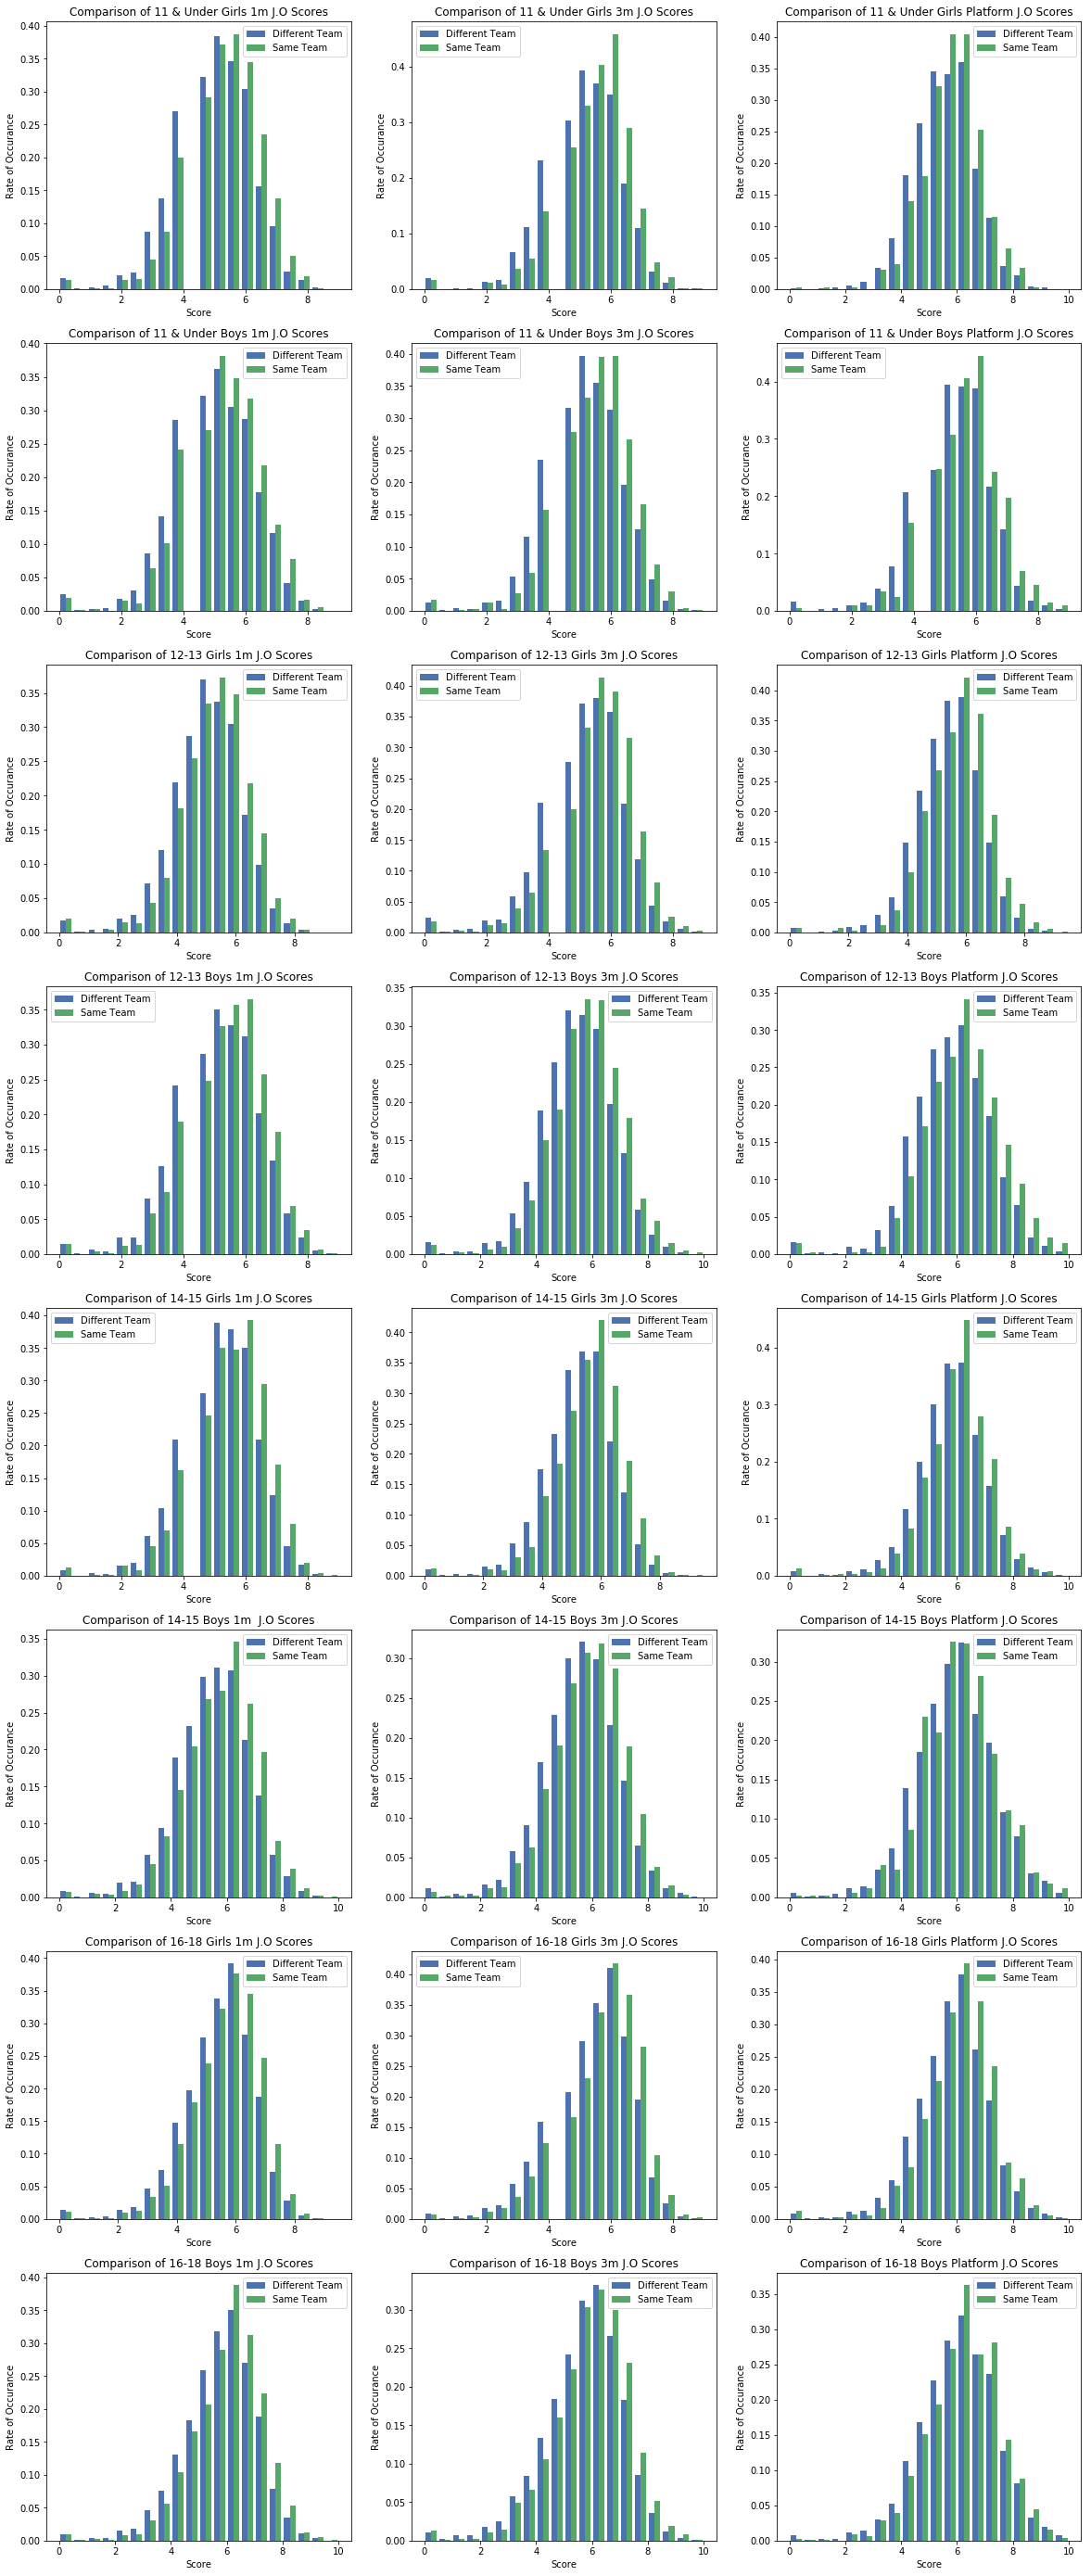

In [ ]:
# define data frame for storing analysis values
events_df = pd.DataFrame(columns=['Event', 'Different', 'Same', 't value', 'p value'])

%matplotlib inline
# set up for plots three across
plt.subplots(ncols=3, figsize=(20, 50))
plt.style.use('seaborn-deep')

# define index for plot placement
i = 0
    
for event in event_list:
    
    i = i + 1
   
    # Make a separate list of scores for each event
    x1 = list(sdata0[sdata0['event'] == event]['score'])
    x2 = list(sdata1[sdata1['event'] == event]['score'])


    # Find the right spot on the plot grid
    plt.subplot(8,3,i)
    
    # Make the histogram using the lists
    # Normalize the scores and assign colors and names
    plt.hist([x1, x2], bins = 20, density=True, label=names)
    #         color = colors, label=names)

    # Plot formatting
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Rate of Occurance')
    plt.title('Comparison of ' + event + ' Scores')

    t, p = stats.ttest_ind(x1, x2)
    events_df = events_df.append({'Event': event, 'Different': len(x1), 'Same': len(x2), 't value': t, 'p value' : p}, 
                           ignore_index=True)
    


In [ ]:
print(events_df)

                            Event Different  Same    t value       p value
0         11 & Under Girls 1m J.O     21180  2361 -11.151441  8.320264e-29
1         11 & Under Girls 3m J.O     15458  1905 -11.422554  4.132705e-30
2   11 & Under Girls Platform J.O      5255   647  -4.873256  1.126442e-06
3          11 & Under Boys 1m J.O     13913  1734  -6.957789  3.593668e-12
4          11 & Under Boys 3m J.O      9910  1430  -8.646146  6.041783e-18
5    11 & Under Boys Platform J.O      3165   449  -4.764497  1.967764e-06
6              12-13 Girls 1m J.O     41483  4041 -11.722367  1.087350e-31
7              12-13 Girls 3m J.O     34006  3737 -15.006755  9.294270e-51
8        12-13 Girls Platform J.O     10950  1188  -8.262096  1.579396e-16
9               12-13 Boys 1m J.O     23957  2734  -9.279853  1.821853e-20
10              12-13 Boys 3m J.O     20641  2308  -9.883772  5.441759e-23
11        12-13 Boys Platform J.O      7526   831  -6.917858  4.923112e-12
12             14-15 Girl

The results displayed above contain the event name, the count of average scores given by judges/coaches from different teams than the diver, the count of average score given by judges/coaches on the same team as the diver, the t value, and the p value. These results again indicate that a statistically significant difference exists for the average scores given across all age groups and events. When we looked at the average scores given, we found there was one event, 14-15 Boys Platform, where the difference was not significant. This is not the case when we look at the raw scores given. There is a significant difference between the scores given by judges/coaches from the same team when compared with scores given by judges/coaches from different teams. Looking at the raw scores gives a more accurate result because it is looking at every score instead of a combination and average of scores.

We can again look at the scores grouped by the 12 different regions. Again, it is seen that the score of 4 is missing completely from 2 different regions, regions 1 and 12, for the entire 3 year time range. This indicates that no diver in any event received a score of 4 on any of their dives in those two regions.

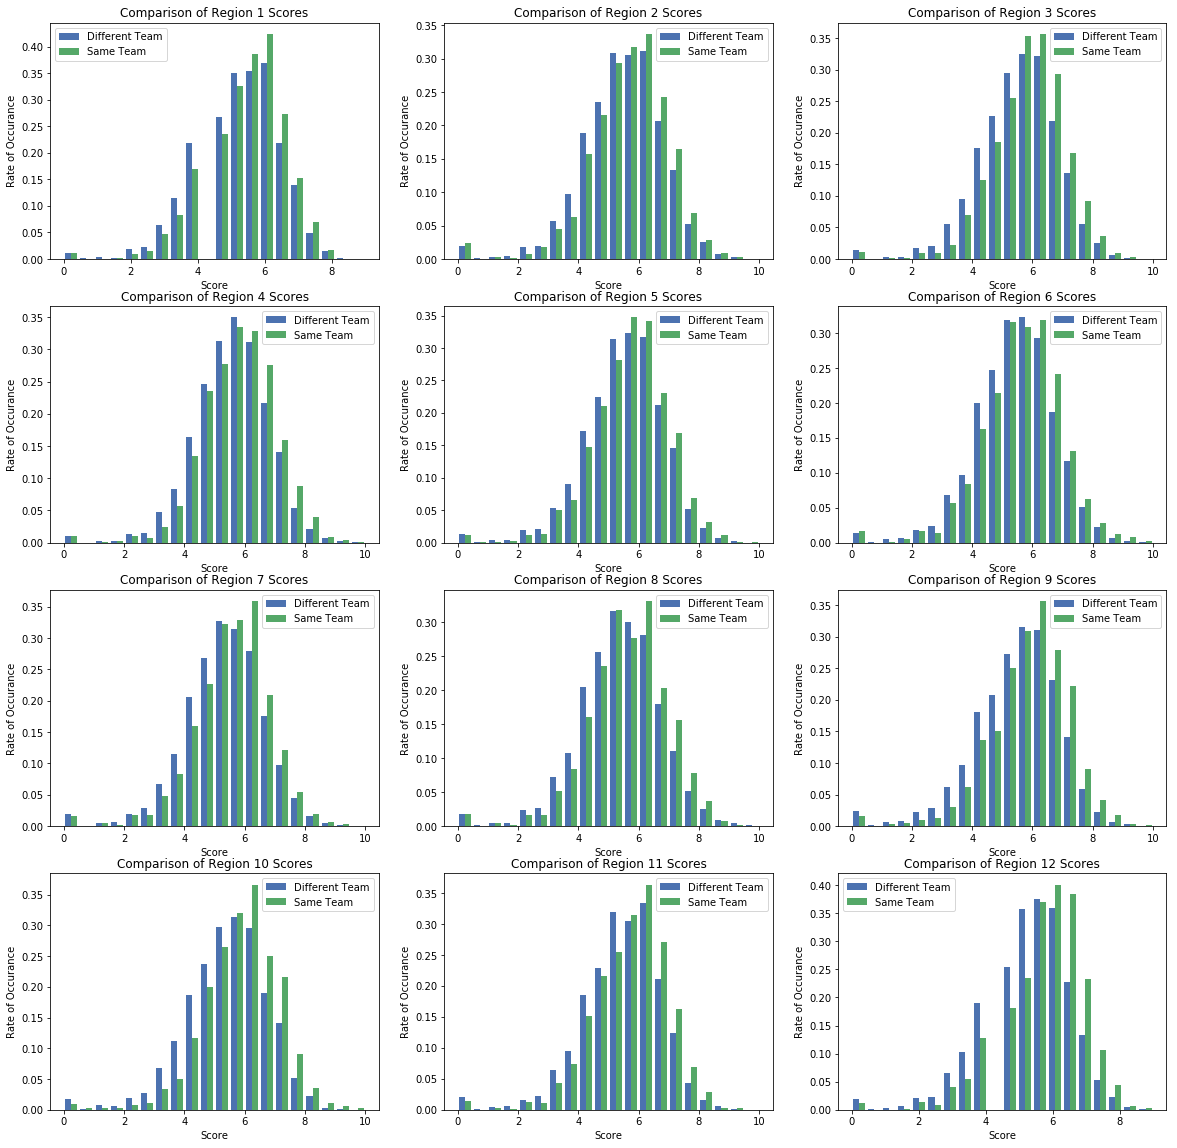

In [ ]:
# set up for plots three across
plt.subplots(ncols=3, figsize=(20, 20))
plt.style.use('seaborn-deep')

# define data frame for storing analysis values
regs_df = pd.DataFrame(columns=['Region', 'Different', 'Same', 't value', 'p value'])

# define index for plot placement
i = 0
  
for region in region_list:
    
    i = i + 1
   
    # Make a separate list of scores for each event
    x1 = list(sdata0[sdata0['meet'] == region]['score'])
    x2 = list(sdata1[sdata1['meet'] == region]['score'])

    #print('Different records = ', len(x1), ' Same records = ', len(x2))
    
    # Find the right spot on the plot grid
    plt.subplot(4,3,i)
    
    # Make the histogram using the lists
    # Normalize the scores and assign colors and names
    plt.hist([x1, x2], bins = 20, density=True, label=names)
    #         color = colors, label=names)

    # Plot formatting
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Rate of Occurance')
    plt.title('Comparison of ' + region + ' Scores')

    t, p = stats.ttest_ind(x1, x2)
    regs_df = regs_df.append({'Region': region, 'Different': len(x1), 'Same': len(x2), 't value': t, 'p value' : p}, 
                             ignore_index=True)
    

In [ ]:
print(regs_df)

       Region Different  Same    t value        p value
0    Region 1     26513  2637  -8.072169   7.169686e-16
1    Region 2     35423  3919  -7.809881   5.865488e-15
2    Region 3     34636  3425 -13.433049   4.802704e-41
3    Region 4     24067  4336 -10.663609   1.690801e-26
4    Region 5     32800  5081  -8.862086   8.187383e-19
5    Region 6     21249  3746  -7.867597   3.760791e-15
6    Region 7     24512  2786  -8.422837   3.852789e-17
7    Region 8     31913  2743  -8.257157   1.544154e-16
8    Region 9     17997  3083 -14.422607   6.240803e-47
9   Region 10     21110  2513 -15.879186   1.731893e-56
10  Region 11     23231  2279  -8.873692   7.529916e-19
11  Region 12     37097  4779 -23.174230  4.597931e-118


The results displayed above contain the region, the count of average scores given by judges/coaches from different teams than the diver, the count of average score given by judges/coaches on the same team as the diver, the t value, and the p value. The statistically significant difference in scores remains true for the raw scores when grouped by region.<br>

Now the data will be grouped by zones. When the data is grouped this way, there are no zones where a score of 4 was not given over the 3 years. 

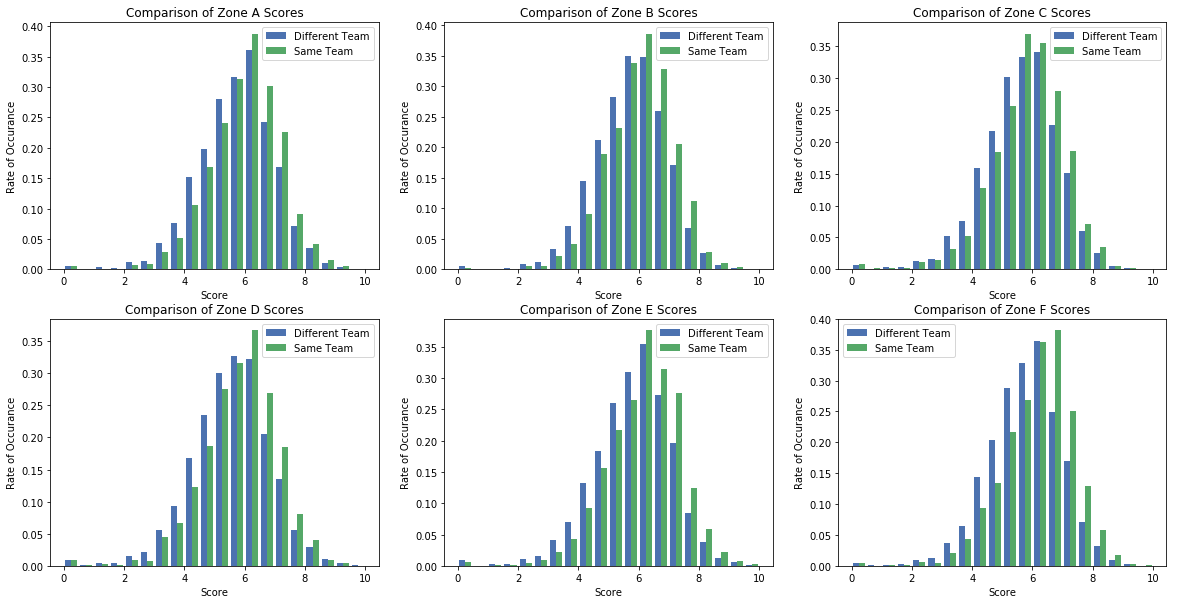

In [ ]:
# set up for plots three across
plt.subplots(ncols=3, figsize=(20, 10))
plt.style.use('seaborn-deep')

# define data frame for storing analysis values
zones_df = pd.DataFrame(columns=['Zone', 'Different', 'Same', 't value', 'p value'])

# define index for plot placement
i = 0

for zone in zone_list:
    
    i = i + 1
   
    # Make a separate list of scores for each event
    x1 = list(sdata0[sdata0['meet'] == zone]['score'])
    x2 = list(sdata1[sdata1['meet'] == zone]['score'])

    #print('Different records = ', len(x1), ' Same records = ', len(x2))
    
    # Find the right spot on the plot grid
    plt.subplot(2,3,i)
    
    # Make the histogram using the lists
    # Normalize the scores and assign colors and names
    plt.hist([x1, x2], bins = 20, density=True, label=names)
    #         color = colors, label=names)

    # Plot formatting
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Rate of Occurance')
    plt.title('Comparison of ' + zone + ' Scores')

    t, p = stats.ttest_ind(x1, x2)
    zones_df = zones_df.append({'Zone': zone, 'Different': len(x1), 'Same': len(x2), 't value': t, 'p value' : p}, 
                               ignore_index=True)
    

In [ ]:
print(zones_df)

     Zone Different  Same    t value       p value
0  Zone A     63863  4991 -13.348274  1.361845e-40
1  Zone B     47205  3568 -13.192919  1.120372e-39
2  Zone C     43438  4454  -9.742424  2.085177e-22
3  Zone D     39870  2656 -10.295127  7.927137e-25
4  Zone E     42785  5176 -16.740245  1.005946e-62
5  Zone F     48513  3032 -17.037417  6.531114e-65


The results displayed above contain the zone, the count of average scores given by judges/coaches from different teams than the diver, the count of average score given by judges/coaches on the same team as the diver, the t value, and the p value. Again, the statistically significant difference in scores remains true for the raw scores when grouped by zone.<br>

In [ ]:
# build datasets for each year
yr2016 = scores_df[scores_df['year'].str.contains("2016")] 
yr2017 = scores_df[scores_df['year'].str.contains("2017")] 
yr2018 = scores_df[scores_df['year'].str.contains("2018")] 

The data can be looked at by year. This again shows the same bias in scoring exists for all three years considered.

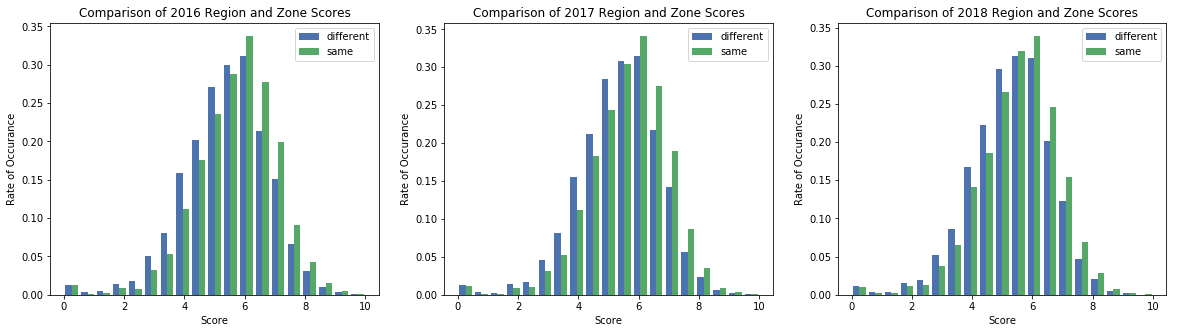

In [ ]:
# set up for plots three across
plt.subplots(ncols=3, figsize=(20, 5))
plt.style.use('seaborn-deep')
bins = np.linspace(0, 10, 20)

# define data frame for storing analysis values
years_df = pd.DataFrame(columns=['Year', 'Different', 'Same', 't value', 'p value'])


####################
# 2016 Scores
####################

plt.subplot(1,3,1)

sydata0 = yr2016[yr2016['same'] == 0]
sydata1 = yr2016[yr2016['same'] == 1]

x = sydata0['score']
y = sydata1['score']

plt.hist([x, y], bins, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of 2016 Region and Zone Scores')
plt.xlabel('Score')
plt.ylabel('Rate of Occurance')

t, p = stats.ttest_ind(x, y)
years_df = years_df.append({'Year': '2016', 'Different': len(x), 'Same': len(y), 't value': t, 'p value' : p}, 
                           ignore_index=True)

####################
# 2017 Scores
####################

plt.subplot(1,3,2)

sydata0 = yr2017[yr2017['same'] == 0]
sydata1 = yr2017[yr2017['same'] == 1]

x = sydata0['score']
y = sydata1['score']

plt.hist([x, y], bins, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of 2017 Region and Zone Scores')
plt.xlabel('Score')
plt.ylabel('Rate of Occurance')

t, p = stats.ttest_ind(x, y)
years_df = years_df.append({'Year': '2017', 'Different': len(x), 'Same': len(y), 't value': t, 'p value' : p}, 
                           ignore_index=True)

####################
# 2018 Scores
####################

plt.subplot(1,3,3)

sydata0 = yr2018[yr2018['same'] == 0]
sydata1 = yr2018[yr2018['same'] == 1]

x = sydata0['score']
y = sydata1['score']

plt.hist([x, y], bins, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of 2018 Region and Zone Scores')
plt.xlabel('Score')
plt.ylabel('Rate of Occurance')

t, p = stats.ttest_ind(x, y)
years_df = years_df.append({'Year': '2018', 'Different': len(x), 'Same': len(y), 't value': t, 'p value' : p}, 
                           ignore_index=True)


In [ ]:
print(years_df)

   Year Different   Same    t value        p value
0  2016    189320  19405 -28.308332  5.888967e-176
1  2017    206913  22679 -30.472138  1.558702e-203
2  2018    219989  23120 -24.192737  3.775669e-129


The results displayed above contain the year, the count of average scores given by judges/coaches from different teams than the diver, the count of average score given by judges/coaches on the same team as the diver, the t value, and the p value. The difference in the raw scores given is statistically significant for all three years.

#### Data Exploration and Analysis by Judge/Coach
We can look at the data by judge. For each judge/coach that gave scores to a diver on their same team, we will find the average score they gave to divers on their same team and the average score they gave to divers on different teams.

In [ ]:
# get a list of unique judge names from the data where diver and judge teams match
judge_list = data1.judge.unique()
#print(judge_list)

# define data frame for storing info on judges
judge_df = pd.DataFrame(columns=['Judge', 'S_T_Score', 'S_Score_Cnt', 'S_Ave_Score', 
                                 'D_T_Score', 'D_Score_Cnt', 'D_Ave_Score'])

In [ ]:
# go through the list of judges that have scored divers from their same team
for judge in judge_list:
    
    # initialize the values for the data collected for this judge
    s_score_cnt = 0
    s_total_score = 0
    d_score_cnt = 0
    d_total_score = 0
    #print('judge = ', judge)
    
    # look through the dataframe where judges scored a diver from their team
    for idx in data1.index:

        # if the current judge matches the judge in this record
        if data1['judge'][idx] == judge:
            # get the total count of scores given
            s_score_cnt = s_score_cnt + data1['score_cnt'][idx]
            # get the total of the scores given
            s_total_score = s_total_score + data1['t_score'][idx]
        
    # look through the dataframe where judges scored a diver from another team
    for idx in data0.index:        

        # if the current judge matches the judge in this record
        if data0['judge'][idx] == judge:
            # get the total count of scores given
            d_score_cnt = d_score_cnt + data0['score_cnt'][idx]
            # get the total of the scores given
            d_total_score = d_total_score + data0['t_score'][idx]
            
            
            
    # append the data collected to the datafrome for judge info
    #print('Judge:', judge, '| S_T_Score =', s_total_score, 'S_Score_Cnt =', s_score_cnt, 
    #                         'D_T_Score =', d_total_score, 'D_Score_Cnt =', d_score_cnt)        
    judge_df = judge_df.append({'Judge': judge, 
                                'S_T_Score': s_total_score, 'S_Score_Cnt': s_score_cnt, 
                                'S_Ave_Score': s_total_score/s_score_cnt,
                                'D_T_Score' : d_total_score, 'D_Score_Cnt': d_score_cnt, 
                                'D_Ave_Score': d_total_score/d_score_cnt}, 
                                ignore_index=True)
            

The plot shows a comparison of average scores given by each judge when the diver and judge/coach are on the same team vs the average scores given when the diver and judge are on a different team. There is one record per judge. This reduces the likelyhood that judges scoring a lot of different divers have resulted in more records and are skewing the results if they are the only ones biased. The plot here looks like the judges give a narrower range of scores to divers from other teams and are more likely to have a wider range of scores for their own divers. This is because judges generally give more scores to divers from other teams than they do to their own divers resulting in a more normal distribution to the scores given to other divers as a resul of the larger number of data values. It also looks like divers are more likely to receive a higher average score from their own coaches. Visually, that difference looks to be about 0.2 which is consistant with the 0.250051 and 0.253121 found above. The limitation of this chart is that it does not compare an individual judge/coach score for same team and different team divers but only an overall comparison.

In [ ]:
# set plot size
plt.subplots(figsize=(10, 5))
plt.style.use('seaborn-deep')
bins = np.linspace(0, 10, 40)

plt.hist([judge_df['D_Ave_Score'], judge_df['S_Ave_Score']], 40, label=['different', 'same'], density=True)
plt.legend(loc='upper right')
plt.title('Comparison of Average Judge Scores')
plt.xlabel('Score')
plt.ylabel('Rate of Occurance')

To directly compare an individual judge's scoring for their own team divers vs other team divers, we can find the difference between the judge's average score for their own divers and the average score for other divers. The plot below shows the distribution of the difference in scores. Negative numbers indicate that a judge gave a lower average score to divers on the same team vs divers on a different team. Positive number indicate that a judge gave a higher average score to divers on the same team vs divers on a different team. 

In [ ]:
# get the difference between the average score given to divers on the same team vs divers on another team
judge_df['Score_diff'] = judge_df['S_Ave_Score']-judge_df['D_Ave_Score']
# set plot size
plt.subplots(figsize=(10, 5))
plt.hist(judge_df['Score_diff'], 40)

plt.title('Difference Between Average Judge Scores for Divers on Same Team vs Divers on Different Teams')
plt.xlabel('Difference')
plt.ylabel('Rate of Occurance')

The histogram shows there were more judges giving a higher average score to their own divers than to divers from other teams. How many judges are we talking about? No judges had an average score given to their own divers that was exactly equal to the average score they gave other divers. The number of judges giving higher scores to their own divers was 216 versus 116 that gave lower scores to their own divers. There are some obvious outliers on the low side of this histogram. The maximum and minimum score differences will be considered later.

In [ ]:
print('Number of Judges giving higher average scores to their own divers ', len([1 for i in judge_df['Score_diff'] if i > 0]))
print('Number of Judges giving the same scores ', len([1 for i in judge_df['Score_diff'] if i == 0]))
print('Number of Judges giving lower average scores to their own divers ', len([1 for i in judge_df['Score_diff'] if i < 0]))

When we look at the mean for the average scores given by a judge to affiliated  (S_Ave_Score) and non-affiliated  (D_Ave_Score) divers by individual judges who gave higher scores to their own divers, we see that the affiliated scores average 0.389687 points (5.686313 - 5.296626) higher than the non-affiliated scores.

In [ ]:
judge_high_df = judge_df[judge_df.Score_diff > 0]
judge_low_df = judge_df[judge_df.Score_diff < 0]
judge_high_df.describe().transpose()

When we look at the mean for the average scores given by a judge to affiliated (S_Ave_Score) and non-affiliated (D_Ave_Score) divers by individual judges who gave lower scores to their own divers, we see that the affiliated score averages 0.425122 points (5.357373 - 4.932251) lower than the non-affiliated scores.

In [ ]:
judge_low_df.describe().transpose()

The judges giving lower scores to their own divers tend to score on average lower than the higher scoring judges score high.

The statistics above looked at each judge without consideration for how many scores were given. When we look at how many scores are given by judges scoring their own divers higher vs judges scoring their own divers lower, we can see that the higher scoring judges give an average of 249.73 scores to their own diver and 1922.02 scores to other divers vs lower scoring judges giving 105.03 scores to their own divers vs 1333.24 scores to other divers. Looking at scores grouped by judges rather than raw scores reduces the effects of the higher scoring judges since the larger number of scores they have given is not considered.

In [ ]:
print('For Judges giving higher scores to divers on the same team as the judge/coach:')
print('Total count of scores given to divers on the same team = ',judge_high_df['S_Score_Cnt'].sum(axis = 0))
print('Total count of scores given to divers on a different team = ',judge_high_df['D_Score_Cnt'].sum(axis = 0))
print('Average number of scores given to divers on the same team = ',judge_high_df['S_Score_Cnt'].sum(axis = 0)/len([1 for i in judge_df['Score_diff'] if i > 0]))
print('Average number of scores given to divers on a different team = ',judge_high_df['D_Score_Cnt'].sum(axis = 0)/len([1 for i in judge_df['Score_diff'] if i > 0]))

In [ ]:
print('For Judges giving lower scores to divers on the same team as the judge/coach:')
print('Total count of scores given to divers on the same team = ',judge_low_df['S_Score_Cnt'].sum(axis = 0))
print('Total count of scores given to divers on a different team = ',judge_low_df['D_Score_Cnt'].sum(axis = 0))
print('Average number of scores given to divers on the same team = ',judge_low_df['S_Score_Cnt'].sum(axis = 0)/len([1 for i in judge_df['Score_diff'] if i < 0]))
print('Average number of scores given to divers on a different team = ',judge_low_df['D_Score_Cnt'].sum(axis = 0)/len([1 for i in judge_df['Score_diff'] if i < 0]))

We can see the results of this reduced effect when looking at the difference in the average scores given to affiliated and non-affiliated divers grouped by judge/coach. Looking at scoring this way, only an increase of 0.104996 points (5.422846 - 5.317850) is found for affiliated scores over non-affiliated scores.

In [ ]:
judge_df.describe().transpose()

In [ ]:
x = judge_df['S_Ave_Score']
y = judge_df['D_Ave_Score']
#print(x,y)
t, p = stats.ttest_ind(x, y)
print('t value = ', t, 'p value = ', p)

The P-value of 0.00036182643101135864 when comparing the average judge score for divers on the same team (S_Ave_Score) vs divers on a different team (D_Ave_Score) indicating that the difference for the average scores given is significant, even with a smaller difference in scores than found with the other analysis methods.

We can look at the top 10 judges that had the highest different between the scores they gave divers on their team vs divers on a different team. This, by itself is not a definitive show of bias. If a judge/coach has diver that is better than all the other divers in their group, the judge/coach may be justified in having a higher average score for their own diver compared to other divers. This should be the exception though, and not the rule. 

In [ ]:
judge_df.nlargest(10, ['Score_diff']) 

We can look at the top 10 judges that had the lowest different between the scores they gave divers on their team vs divers on a different team. These judges giving the lowest scores could have a diver that is worse than the average diver and therefore warrants a lower score. Since most of these judges have given less than 10 scores to their own diver, it is likely there is only one diver from the judge's team competing and that they are not as good as the other divers.<br><br>
When we look at the count of the scores given to diver on the same team (S_Score_Cnt) and on a different team (D_Score_Cnt) and compare these couonts for the judges giving higher scores to the judges giving lower scores, we can see that the  count of scores given is much higher for the top 10 judges scoring their divers higher than for the 10 judges giving the lowest scores to their own divers. Using the analysis by judge/coach weights each judge entry equally. In actuality, the judges giving more scores have a greater effect on the outcome than the judges only giving a few scores. 

In [ ]:
judge_df.nsmallest(10, ['Score_diff']) 

#### Summary
The following results were obtained when we looked at the average score per record and when the scores were separated out so that each score given was its own record. In both cases, the scores given to divers on the same team as the judge/coach were higher than the scores given to divers on a different team.

|Dataset|Same Team<br>Mean Score|Same Team<br> Record Count|Different Team<br>Mean Score|Different Team<br>Record Count|Difference of<br>Mean Scores|
|--|--|--|--|--|--|
|Average Scores    | 5.588800 |	15,925 | 5.338749 |	172,743 | 0.250051 |
|Individual Scores | 5.591444 |	65,204 | 5.338323 |	616,222	| 0.253121 |

When the data is reorganized so that there is one record for each judge that gave scores to a diver from their own team, and the records grouped by judges who gave higher scores to their own divers and judges who gave lower scores to their own divers, we see that 65% (216 out of 332) of the judges/coaches gave higher scores to their own divers. The judges that scored their own divers lower shows a greater difference in scores than with the judges that scored higher. The 65% of the judges scoring higher are responsible for 73.76% of the total scores given ( (415,157+53,941)/(415,157+53,941+12,183+154,656) ) and 81.58% of the scores given to divers on the same team ( 53,941/(53,941+12,183) ).

|Dataset| Record<br> Count | Same Team<br>Mean Score | Same Team<br> Count of Scores | Different Team<br>Mean Score | Different Team<br>Count of scores | Difference of<br>Mean Scores |
|--|--|--|--|--|--|--|
|Judges High  | 216 | 5.686313 | 53,941 | 5.296626 | 415,157 |  0.389687 |
|Judges Low   | 116 | 4.932251 | 12,183 | 5.357373 | 154,656 | -0.425122 |



#### Conclusion:<br>
The data analysis indicates that bias exists in the form of a higher likelihood of a greater score being given to a diver from a coach/judge on the same team than by a coach/judge from a different team. Just how much difference can a higher score from and affiliated judge/coach's make? If we look at the most dives performed, which is eleven, and the greatest average difference in score given, which is 1.351, we can determine the largest impact in scores. Total score is calculated by multiplying the judges score by the degree of difficulty (DD) of the dive. The divers competing eleven dives have 5 dives with a maximum DD of 9.5. The remaining 6 dives have no limitation but for the 16-18 boys can average over 3.0 per dive for a total of 18.0 DD for those dives. The total DD for the eleven dives would be 27.5. When this is multiplied by the increased average score from the affiliated judge/coach giving the highest increased scores, the result is the potential increase of 37.1525 points for the total score. If we look at the average increase in score of 0.253121 for the raw scores (likely the most accurate measure), the potential increase in total score for 11 dives would be 6.96 points. Looking at the smallest number of dives in an event, which is 5, and a likely average DD around 8.5, the potential increase in total score is 2.15 points. There is a definite advantage to having your own coach as a judge. The more dives competed and the more difficult the dives, the bigger difference a slight increase in scoring will make. 

#### Study Limitations:<br>
The judge/coach team is the current team (as of fall 2019) for the coach. If a coach changed teams during the three years of the data collection the team affiliations would be incorrect for the dates before the team change. This study did not take into account the actual effect that an increased score from an affiliated judge/coach may have had on the outcome of a meet, nor did it consider that the highest and lowest score for a diver was not included in the final score calculation. 

#### Additional Study Possibilities:<br>
This study was designed to answer the question of whether bias existed. Additional analysis could answer questions such as the effect bias may have had on a diver’s total score, the effect bias may have had on the outcome of a meet, and if an individual judge is biased. <br><br>
To determine the effect bias may have on the outcome of a meet, each individual dive performed by each diver in each event for each meet needs to be considered. Look at the scores given for that dive, comparing the score from an affiliated judge/coach to the scores given by judges/coaches from other teams. Another score list could be created by replacing the affiliated judge/coach score by the average score from the non-affiliated judges/coaches. The total score could be calculated for each set of scores, dropping the high and low score (as is the normal practice) and retaining the middle three scores, summing those three scores and then multiplying that total by the degree of difficulty for the dive (the normal process for calculating the score for a dive). The two resulting scores could then be compared. This would give an accurate picture of the effect of any affiliated judging bias on the scores for a diver and it could be determined if the final results were affected. Similar analysis would be required to answer additional questions.